In [212]:
#Reading in packages to be used later in the report

import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

<div style="border: 4px solid black; padding: 10px;">
    <h1 style="color: black;">COMP47350: Homework 2.</h1>
</div>

This report will focus on building and evaluating predictive models that focus on the relationship between the descriptive features and the target feature 'death_yn'. Using data provided by the CDC, this report will build a model for death risk prediction. 

For this assignment, I have opted to use the cleaned dataset (cleaned_data.csv) which was created in Homework 1. 

In [2]:
#Reading in CSV file into DataFrame 
df = pd.read_csv('cleaned_data.csv')

#Test printing first five lines of cleaned dataset 
df.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2021-01,NC,37.0,FORSYTH,37067.0,65+ years,Male,White,Non-Hispanic/Latino,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Unknown,Yes,NaN
1,2021-12,CA,6.0,LOS ANGELES,6037.0,65+ years,Male,White,Hispanic/Latino,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Unknown,No,Missing,Yes,NaN
2,2020-12,CA,6.0,LOS ANGELES,6037.0,50 to 64 years,Male,White,Hispanic/Latino,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,Yes,NaN
3,2020-11,MN,27.0,NOBLES,27105.0,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,Missing,Missing,Yes,Yes
4,2020-03,IL,17.0,COOK,17031.0,50 to 64 years,Male,Black,Non-Hispanic/Latino,NaN,0.0,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Yes,NaN


While this dataset has undergone initial cleaning, from working with it in Assignment 1 I am aware that it contains many missing values, NaNs and other problematic areas. Before conducting further work with it, I will conduct additional data cleaning in line with my choices from Assignment 1. All steps will be clearly explained as I proceed. 

Before commencing work, I will print the types of each column. This will inform decisions made later in the report. 

In [3]:
#Select all columns of type 'object'
object_columns = df.select_dtypes(['object']).columns

#Convert object data to type 'category'
for column in object_columns:
    df[column] = df[column].astype('category')  

df.dtypes #reprint all data frame types to evaluate

case_month                         category
res_state                          category
state_fips_code                     float64
res_county                         category
county_fips_code                    float64
age_group                          category
sex                                category
race                               category
ethnicity                          category
case_positive_specimen_interval     float64
case_onset_interval                 float64
process                            category
exposure_yn                        category
current_status                     category
symptom_status                     category
hosp_yn                            category
icu_yn                             category
death_yn                           category
underlying_conditions_yn           category
dtype: object

**Null values**

From previous work with the dataset, I am aware that it contained many null values. Below, I will print the count of null values from each column for further analysis as a percentage, which informs my future decisions as to how handle each case.. 

In [4]:
# Calculate the percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Print the percentage of missing values for each column
print("Percentage of missing values for each column:")
print(missing_percentage)

Percentage of missing values for each column:
case_month                          0.000000
res_state                           0.000000
state_fips_code                     0.000000
res_county                          5.851076
county_fips_code                    5.851076
age_group                           0.845008
sex                                 2.380585
race                               12.827358
ethnicity                          14.131274
case_positive_specimen_interval    46.523993
case_onset_interval                55.653613
process                             0.000000
exposure_yn                         0.000000
current_status                      0.000000
symptom_status                      0.000000
hosp_yn                             0.000000
icu_yn                              0.000000
death_yn                            0.000000
underlying_conditions_yn           91.402096
dtype: float64


From the previous code cells, I ascertain the following. 

- Categorical columns with null values are: county_fips_code, case_positive_specimen_interval and case_onset_interval. 

- Continuous columns with null values are: res_county, age_group, sex, race, ethnicity and underlying_conditions_yn. 

From wider reading (of the CDC documentation), I am aware that the CDC redacted patient information in order to preserve anonymity. Therefore, the high count of null values in certain columns is unsurprising. In order to obtain a functional dataset for the model training, I am opting to use the following techniques. 

- For handling continuous columns with null values, I will be imputing using the mean/median/mode imputation strategy. Precise selection of which to use will depend on how skewed the column data is and will be covered at a later point in this section. 

- For handling categorical columns with null values, I will be imputing using the forward fill as it will preserve temporal order in the dataset. 

- However, the percentage of null values in underlying_conditions_yn makes the feature too unreliable for generation of accurate data. This will regrettably have to be dropped. 

In [5]:
# Dropping the underlying_conditions_yn feature
df.drop('underlying_conditions_yn', axis=1, inplace=True)

The code cell below imputes the categorical columns, using the forward fill technique. 

In [6]:
# Identify categorical columns with missing values
categorical_columns_with_missing = df.select_dtypes(include=['category']).columns[df[df.select_dtypes(include=['category']).columns].isnull().any()]

# Impute missing values using forward fill in the categorical columns 
for column in categorical_columns_with_missing:
    df[column].fillna(method='ffill', inplace=True)

# Check that missing values have been imputed
print("Missing values after forward fill imputation:")
print(df.isnull().sum())

Missing values after forward fill imputation:
case_month                             0
res_state                              0
state_fips_code                        0
res_county                             0
county_fips_code                    2652
age_group                              0
sex                                    0
race                                   0
ethnicity                              0
case_positive_specimen_interval    21087
case_onset_interval                25225
process                                0
exposure_yn                            0
current_status                         0
symptom_status                         0
hosp_yn                                0
icu_yn                                 0
death_yn                               0
dtype: int64


/var/folders/3t/zmr1xgmj2y52tg8hg56hl6xc0000gn/T/ipykernel_17939/1717855606.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(method='ffill', inplace=True)
/var/folders/3t/zmr1xgmj2y52tg8hg56hl6xc0000gn/T/ipykernel_17939/1717855606.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='ffill', inplace=True)


Before imputing the continuous data, I would like to perform informative checks to help my decision as to whether I should utilise mean, median or mode imputation. I will calculate and print out the mean, median, mode, standard deviation, variance, skewness, and kurtosis for each continuous column. 

In [7]:
# Filter float64 (continuous) variables
float64_variables = df.select_dtypes(include=['float64'])

# Calculate mean, median, mode
mean_values = float64_variables.mean()
median_values = float64_variables.median()
mode_values = float64_variables.mode().iloc[0]  

# Calculate standard deviation, variance
std_values = float64_variables.std()
var_values = float64_variables.var()

# Calculate skewness and kurtosis
skewness_values = float64_variables.skew()
kurtosis_values = float64_variables.kurt()

# DataFrame to store the descriptive statistics
descriptive_stats = pd.DataFrame({
    'Mean': mean_values,
    'Median': median_values,
    'Mode': mode_values,
    'Standard Deviation': std_values,
    'Variance': var_values,
    'Skewness': skewness_values,
    'Kurtosis': kurtosis_values
})

# Printing descriptive statistics
print("Descriptive Statistics for continuous variables:")
print(descriptive_stats)

Descriptive Statistics for continuous variables:
                                         Mean   Median     Mode  \
state_fips_code                     30.087170     34.0     36.0   
county_fips_code                 30133.844164  34023.0  12086.0   
case_positive_specimen_interval      0.177036      0.0      0.0   
case_onset_interval                 -0.036965      0.0      0.0   

                                 Standard Deviation      Variance  Skewness  \
state_fips_code                           12.999320  1.689823e+02 -0.247921   
county_fips_code                       12861.032019  1.654061e+08 -0.351096   
case_positive_specimen_interval            2.607726  6.800237e+00  5.204553   
case_onset_interval                        1.977101  3.908928e+00  4.373370   

                                   Kurtosis  
state_fips_code                   -0.566418  
county_fips_code                  -0.695612  
case_positive_specimen_interval  728.185959  
case_onset_interval              99

From the results above, I have decided to use median imputation for these columns. 

My rationale for this is that in county_fips_code, the distribution is not heavily skewed and mean/median/mode are relatively close together. I believe that mean, median or mode imputation would all work well with this feature. 

However, in case_positive_specimen_interval and case_onset_interval, the distribution is highly positively skewed and mean and median are significantly different. Therefore, median imputation should be most reliable. The mean will be significantly impacted by outliers in the dataset. 

Below, I will impute values to these features using median imputation. 

In [8]:
# Median imputation column selection
columns_to_impute = ['county_fips_code', 'case_positive_specimen_interval', 'case_onset_interval']

for column in columns_to_impute:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

# Prove that missing values have been imputed
print("Missing values after median imputation:")
print(df.isnull().sum())

Missing values after median imputation:
case_month                         0
res_state                          0
state_fips_code                    0
res_county                         0
county_fips_code                   0
age_group                          0
sex                                0
race                               0
ethnicity                          0
case_positive_specimen_interval    0
case_onset_interval                0
process                            0
exposure_yn                        0
current_status                     0
symptom_status                     0
hosp_yn                            0
icu_yn                             0
death_yn                           0
dtype: int64


/var/folders/3t/zmr1xgmj2y52tg8hg56hl6xc0000gn/T/ipykernel_17939/1386635112.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)
/var/folders/3t/zmr1xgmj2y52tg8hg56hl6xc0000gn/T/ipykernel_17939/1386635112.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

**Additional missing values**

Before commencing work on the dataset, I would like to check for alternate representations of missing values that may impact my work. 

In [9]:
# List of alternative representations of missing values
alternative_missing_values = ["N/A", "NA", "None", "Not available", "Not Avail", "NaN", "Missing"]

# Flag tracking if any alternative missing values are found
found_missing_values = False

# Check for alternative missing values across all features
for column in df.columns:
    unique_values = df[column].unique()
    missing_values = [value for value in unique_values if str(value).strip() in alternative_missing_values]
    if missing_values:
        found_missing_values = True
        print(f"Column '{column}' has alternative missing values: {missing_values}")

# If no alternative missing values are found, print message
if not found_missing_values:
    print("No alternative missing values found across all features.")

Column 'age_group' has alternative missing values: ['Missing']
Column 'sex' has alternative missing values: ['Missing']
Column 'race' has alternative missing values: ['Missing']
Column 'ethnicity' has alternative missing values: ['Missing']
Column 'process' has alternative missing values: ['Missing']
Column 'exposure_yn' has alternative missing values: ['Missing']
Column 'symptom_status' has alternative missing values: ['Missing']
Column 'hosp_yn' has alternative missing values: ['Missing']
Column 'icu_yn' has alternative missing values: ['Missing']


The above clearly shows that multiple columns contain the value 'Missing'. I believe that this is due to CDC data redaction, which the CDC note themselves on their website. While the loss of data may impact future analysis, the goal of preserving patient anonymity is of course of higher priority. 

I considered clearing these Missing values and then imputing them (via forward filling or similar). However, I believe that this will only serve to skew the database. As these values were removed by the CDC data teams, they are not lost at random and thus may be entirely different from the majority of the dataset. It is impossible to select a correct formula to impute them without understanding the rationale for their redaction - and of course, this would require access to patient details. 

While it is disappointing that the analysis will be limited by this, I believe that adjusting the values would not produce more accurate results. 

<div style="border: 3px solid black; padding: 10px;">
    <h2 style="color: black;">Section 1: Data Understanding.</h2>
</div>

<div style="border: 2px solid black; padding: 10px;">
    <h3 style="color: black;">1.1: Splitting the dataset.</h3>
</div>

For this part of the assignment, I need to split the dataset into two sections: 30% test data and 70% training data. To do this, I will utilise the 'train_test_split' function from the 'sklearn.model_selection' module, as it will allow me to define the proportion of the dataset that should be set aside for future testing.  

The test data is saved into a file for future analysis and the percentage values of the training and testing sets are printed, in order to verify that the split was fair and in line with the assignment brief. 

In [9]:
# Splitting the dataset into 70% training and 30% testing
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Checking the lengths of the resulting DataFrames as percentages
total_length = len(df)
train_length = len(train_df)
test_length = len(test_df)

print("Training set size: {:.2%}".format(train_length / total_length))
print("Testing set size: {:.2%}".format(test_length / total_length))

# Saving the test data to a separate CSV file
test_df.to_csv('test_data.csv', index=False)

Training set size: 70.00%
Testing set size: 30.00%


I will now read in the training dataset in order to perform operations on it in future tasks. 

In [10]:
# Assigning train_df as the current DataFrame to work on
df = train_df

<div style="border: 2px solid black; padding: 10px;">
    <h3 style="color: black;">1.2: Actions on the Training Set.</h3>
</div>

This section will cover the following areas: 
- Plot and discuss correlations between all continuous features. 
- Plot and discuss each continuous feature's interaction with 'death_yn'. 
- Choose a subset of continuous features that seem promising in predicting the target feature and explain the choice. 
- For each categorical feature, plot the pairwise interaction with the target feature and the knowledge gained from this interaction. 
- Choose a subset of categorical features that seem promising and justify choices. 

## Plotting and discussing correlations between the continuous features. ##

I have elected to use the corr() method from Pandas to create a correlation matrix, which I will then visualise using a heatmap rendered via seaborn. A heatmap has been selected as it will provide a clear visual representation which should be easy to decode. Additionally, the heatmap will be compact and condense the information into a single plot. As I wish to establish if there are patterns within the data, a heatmap is an ideal way to explore this. 

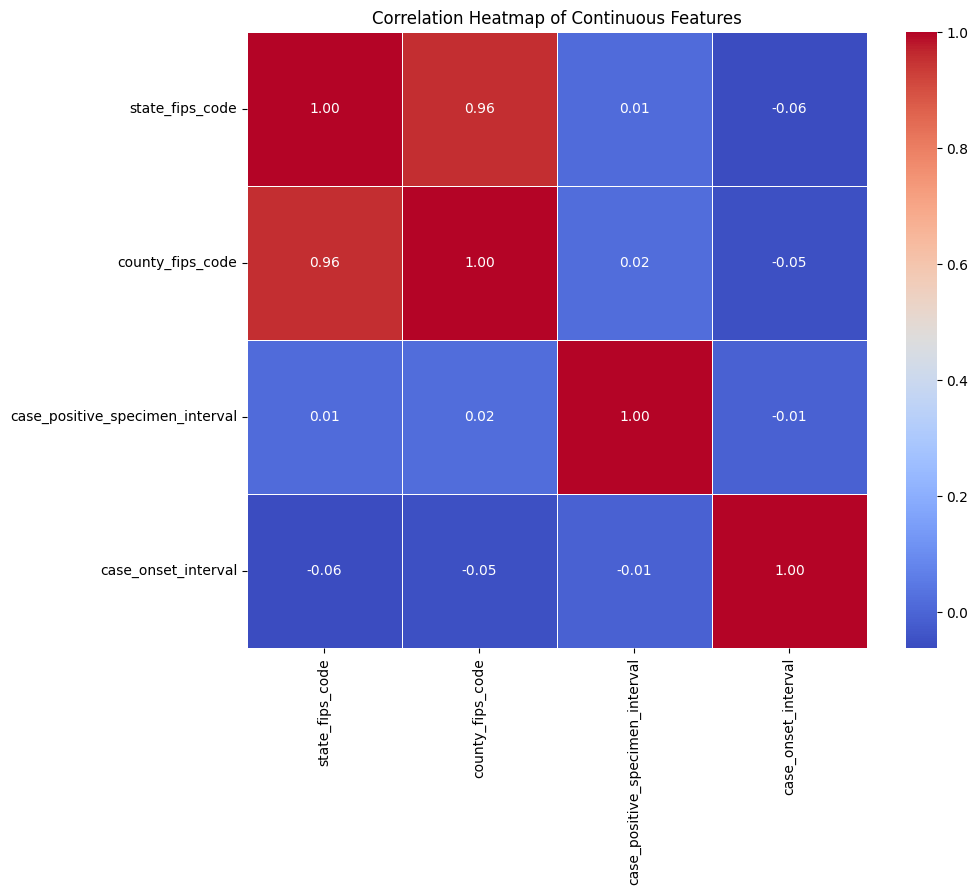

In [26]:
# Filtering for continuous features
continuous_features = df.select_dtypes(include=['float64'])

# Calculating the correlation matrix
correlation_matrix = continuous_features.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap of Continuous Features")
plt.show()

The generated heatmap reveals the following: 

- Correlations appear to either be strongly positive (red) or markedly weak (blue). There is a tendency to skew towards either extreme, with no neutral findings. Overall, the dataset tends to have low correlations between the features. 

- Multicollinearity is indicated in this dataset, indicating a strong positive correlation between state_fips_code and county_fips_code. Given that counties are located within states, this is unsurprising. 

- A diagonal line with intense colour is visible, which indicates a perfect correlation of a feature with itself. 

- The annotation within each cell of the heatmap indicates the correlation coefficient between the features. This is further confirmation of both the feature correlation with itself (1.00 on all) and of the strong positive correlation between state_fips_code and county_fips_code (with a correlation of 0.96). Otherwise, all values are negative or close to zero. This indicates that aside from the state and county codes, the features have weak or negative relationships. 

## Plotting correlations between continuous features and the target feature. ##

As a reminder, the target feature for this report is 'death_yn'. 

To complete this analysis, I opted to first analyse the categorical variables against 'death_yn', before moving on to discussing the continuous features. Doing this made it easier to be concise and comprehensive in my discussion. 

Additionally, I opted to perform a Chi-square test on the categorical features, as well as plotting their correlations to 'death_yn' on heatmaps. My rationale for this was to provide myself with greater insight into the data. While the heatmaps provide an extremely useful visualisation, the sheer number of them can make the data difficult to discuss. 

The chi-square test is used to determine whether there is a significant association between categorical variables in a dataset. The chi-square statistic measures the discrepancy between the observed and expected frequencies of categories within contingency tables. Therefore, the magnitude of the chi-square statistic and associated p-value are crucial. 

A moderate or large chi-square value will indicate a substantial deviation from the null hypothesis of independence. Essentially, it will flag a stronger association between the variables. Conversely, a low p-value (less than 0.05) will indicate that the observed association is unlikely to have occurred by chance. When paired, a large/moderate chi-square value and a low-very low p-value indicate a strong association between the target variables. 

In [33]:
# Selecting only categorical columns
categorical_features = df.select_dtypes(include=['category'])

# Initializing an empty list to store associations
associations_data = []

# Loop through each categorical feature (not 'death_yn')
for column in categorical_features:
    if column != 'death_yn':
        # Create a contingency table for chi-square test
        contingency_table = pd.crosstab(df['death_yn'], df[column])
        
        # Perform chi-square test of independence
        chi2, p, _, _ = chi2_contingency(contingency_table)
        
        # Add results to the associations data list
        associations_data.append({'Feature': column, 'Chi-square': chi2, 'p-value': p})

# Create the associations DataFrame from the associations data list
associations = pd.DataFrame(associations_data)

# Display the DataFrame
print("Associations between 'death_yn' and other categorical features:")
print(associations)

Associations between 'death_yn' and other categorical features:
           Feature    Chi-square        p-value
0       case_month   3812.704288   0.000000e+00
1        res_state   9689.201073   0.000000e+00
2       res_county  11701.884733   0.000000e+00
3        age_group  13511.662136   0.000000e+00
4              sex    217.255882   7.868570e-47
5             race    568.984302  1.158905e-118
6        ethnicity    750.204278  2.724698e-162
7          process    330.163447   1.544472e-66
8      exposure_yn    138.601682   7.998842e-31
9   current_status    169.123403   1.149812e-38
10  symptom_status    184.859154   7.871107e-40
11         hosp_yn  11783.471961   0.000000e+00
12          icu_yn   2557.495089   0.000000e+00


The Chi-Square test reveals the following: 

- *case_month* has a significant correlation with the 'death_yn' variable, with a very low p-value. 

- *res_state* has a highly significant correlation with the target feature, supported by the large chi-square value and the very low p-value. 

- *res_county* has a highly significant correlation with 'death_yn', as evidenced by the large chi-square value and the very low p-value. Given that we have established a strong correlation between "state_fips_code' and 'county_fips_code' in the previous section, it is unsurprising to see further evidence of this correlation here, in that both variables experience high correlation with another. 

- *age_group* There is a highly significant association between death and age group, with a very low p-value. 

- *sex* This feature has a moderately high chi-square value and a low p-value. This indicates a statistically significant association. 

- *race* Between the target feature and race, there is a significant association. This is evidenced by the moderately high chi-square value and low p-value. 

- *ethnicity*  There is a highly significant association between ethnicity and death, evidenced by a large chi-square value and very low p-value. 

- *process* Significant correlation between process and death_yn is seen, supported by a moderate chi-square value and a low p-value.

- *exposure_yn* There is a statistically significant correlation between this feature and 'death_yn'. It has a moderate chi-square value and a low p-value. 

- *current_status* shows a significant correlation to 'death_yn', indicated by a moderate chi-square value and low p-value. 

- *symptom_status* Significant correlation is seen between the target feature and 'symptom_status', supported by the moderate chi-square value and the low p-value. 

- *hosp_yn* A large chi-square value and very low p-value are seen, indicating a highly significant association. 

- *icu_yn* There is a significant association between this feature and 'death_yn', supported by a moderate chi-square value and very low p-value. This result was somewhat of a surprise as I would have assumed that an ICU patient would be at a higher risk of dying. This feature did not require imputation, therefore we cannot attribute this surprise result to accuracy drift. 

Overall, this shows strong associations between death_yn and the other categorical features, indicating that they may be important predictors of death status. The heatmaps below should provide further visual confirmation of these associations. 

For ease of analysis, I have opted to generate heatmaps one at a time and discuss the findings underneath. 

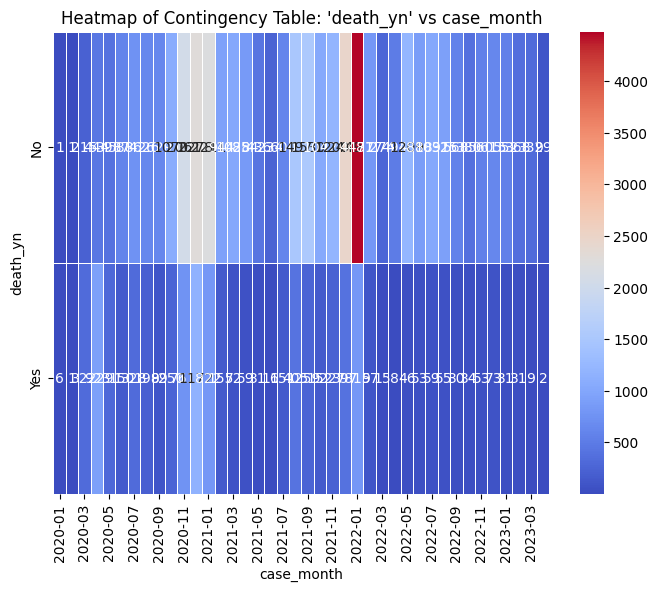

In [26]:
# Visualising the correlation between 'case_month' and 'death_yn'
feature_to_visualize = 'case_month'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

This heatmap clearly shows that there is a strong correlation between patients in January 2022 and survival of Covid 19. However, additional factors may be at play and skewing this information. For example, the code print out below shows clearly that there is a higher count of patients from January 2022 in the dataset, as compared to other entries. For this reason, it is natural that we would see a higher emphasis placed on this entry in the generated heatmap. 

In [27]:
unique_counts = df['case_month'].value_counts()

# Print the top 10 highest counts for 'case_month'
print(unique_counts.nlargest(10))

case_month
2022-01    5292
2020-12    3450
2021-01    3033
2021-12    2846
2020-11    2822
2021-08    1902
2021-09    1789
2021-11    1427
2020-04    1367
2020-10    1320
Name: count, dtype: int64


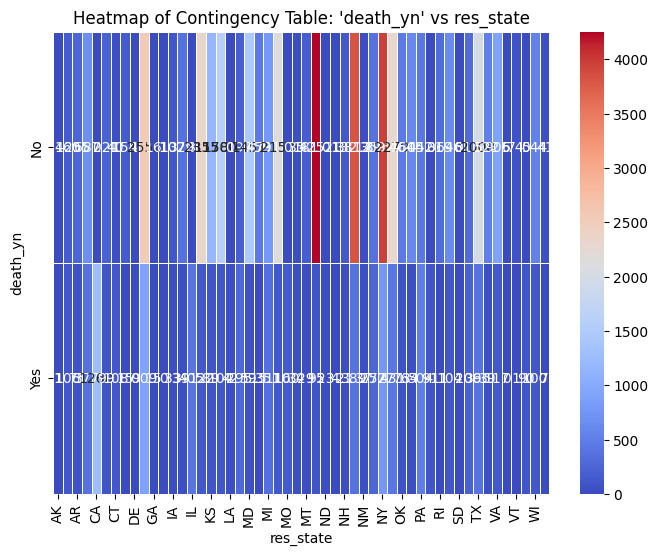

In [20]:
# Visualising the correlation between 'res_state' and 'death_yn'
feature_to_visualize = 'res_state'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

I explored graphing the above as a scatter plot with transparency, in order to improve readability. However, due to the limited values to plot (yes and no), this did not produce readable data. Therefore, while this heatmap is difficult to decode, it is the best solution I could find. 

Overall, the heatmap displays strong correlations between certain states and patients not dying from Covid. It was a little hard to decipher exactly which states these were from the dataset, so the code cell below prints the 10 states with the highest count of patients. It is noticeable that the dataset does not appear evenly split, which may impact future analysis. 

While information on the res_state is useful, additonal information may be required to provide further clarity. For example, the individual states are large and within them, people experience a wide range of access to healthcare, medication etc. Additionally, poverty levels vary hugely. For this reason, while further analysis of this area may be of benefit, it will not be possible to gain a complete understanding of what is at play here. 

In [25]:
unique_counts = df['res_state'].value_counts()

# Print the top 10 highest counts for 'res_state'
print(unique_counts.nlargest(10))

res_state
NY    4738
NC    4347
NJ    4201
FL    3464
OH    2710
IN    2477
TX    2404
MN    2267
KY    1684
MD    1510
Name: count, dtype: int64


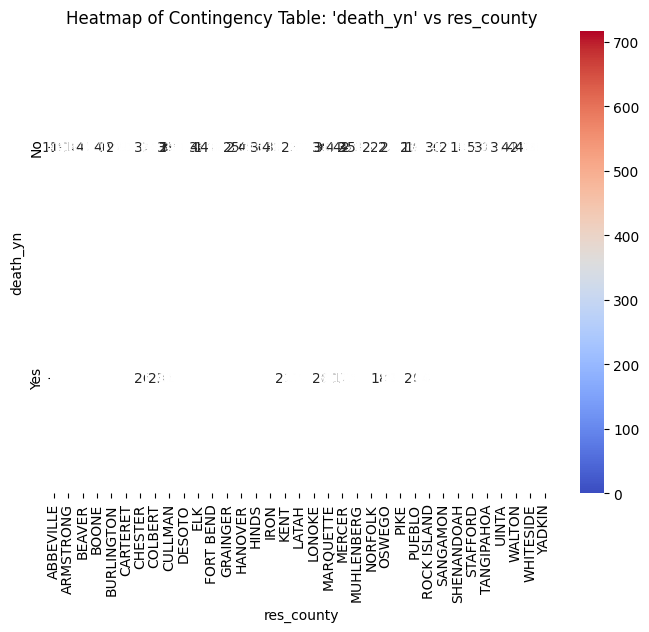

In [19]:
# Visualising the correlation between 'res_county' and 'death_yn'
feature_to_visualize = 'res_county'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

Due to the sheer count of values in 'res_county', visualising this data with a heatmap proved impossible. I considered grouping the 'res_county' values by state and then displaying that, in the hopes of displaying a comprehensible graph. However, I realised that this would essentially return the same data as 'res_state', therefore making the exercise pointless. 

I also explored hexagonal binning in an attempt to render the data but this was also unsuccessful. 

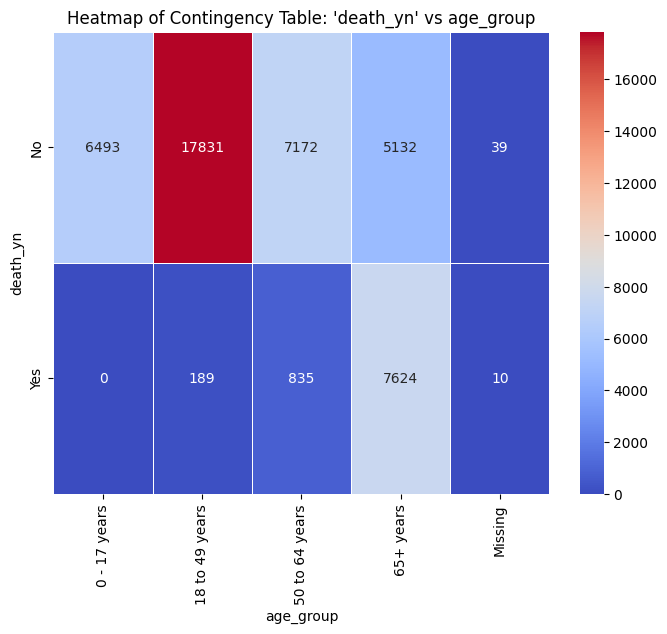

In [17]:
# Visualising the correlation between 'age_group' and 'death_yn'
feature_to_visualize = 'age_group'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

This heatmap bears out the common knowledge about Covid, in that younger people were less likely to die than older people. However, the data also shows (and is reinforced by the FacetGrid below) that this dataset is heavily skewed towards younger people. Therefore, the correlation shown in the heatmap is between a non-death occurrence and a patient in the younger age groups. The lack of balance across the feature limits it. 

While this data is interesting, the limitation must be borne in mind during future analysis. 

/opt/miniconda3/envs/mathsassignment1/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


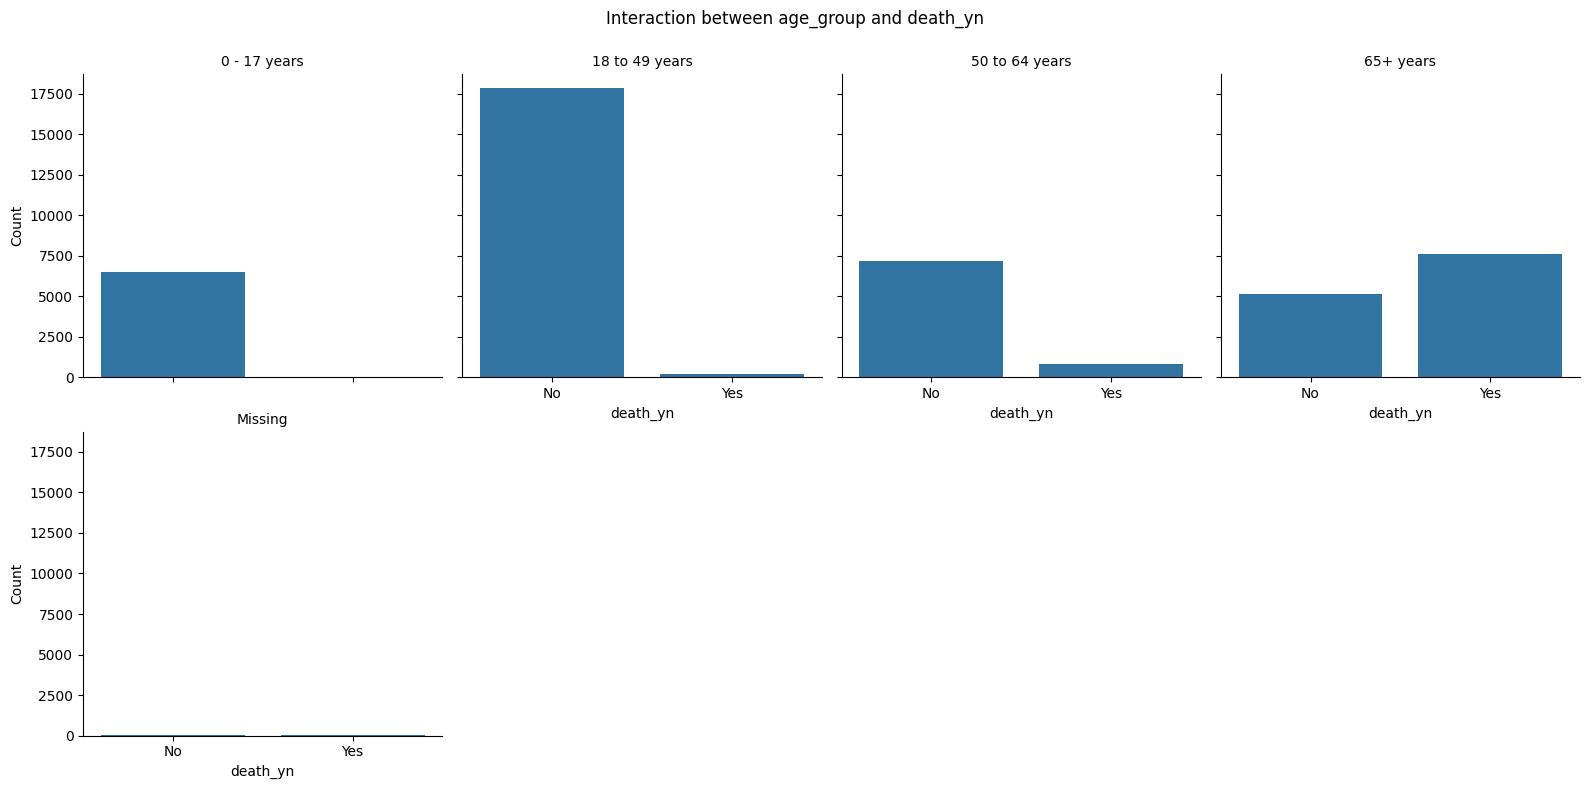

In [18]:
# Generate a FacetGrid of 'age_group'
feature = 'age_group'

# Create a FacetGrid
g = sns.FacetGrid(df, col=feature, col_wrap=4, height=4)

# Map a plot onto the FacetGrid
g.map(sns.countplot, 'death_yn')

# Set titles for each subplot
g.set_titles('{col_name}')

# Add axis labels and adjust spacing
g.set_axis_labels('death_yn', 'Count')
plt.subplots_adjust(top=0.9)
g.fig.suptitle(f'Interaction between {feature} and death_yn')

# Show the plot
plt.show()

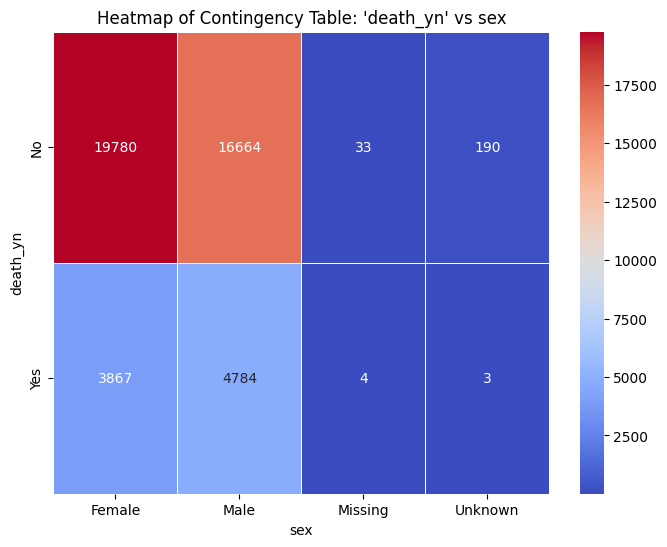

In [16]:
# Visualising the correlation between 'sex' and 'death_yn'
feature_to_visualize = 'sex'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

The heatmap generated shows that overall, both sexes were more likely to survive Covid than to die with it. However, male patients were at a higher risk of death than female patients. It may prove useful in training the models later. 

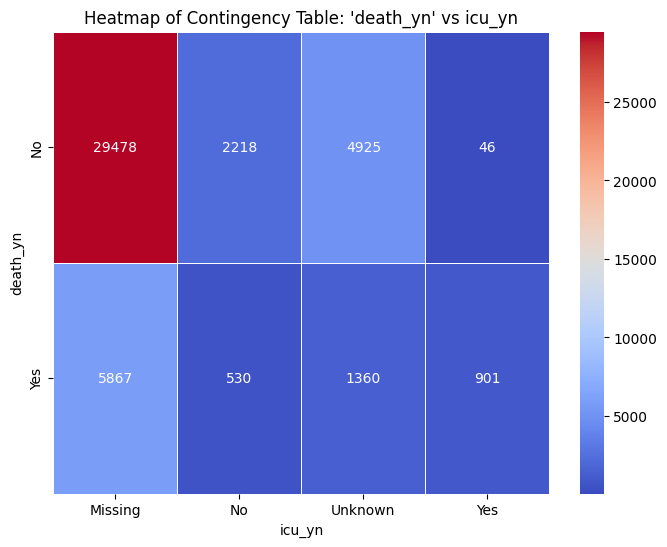

In [15]:
# Visualising the correlation between 'icu_yn' and 'death_yn'
feature_to_visualize = 'icu_yn'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

Previously in the chi-square test, I noted that I was surprised by the results not indicating a strong correlation between patient death and icu status. The heatmap above provides insights on these results. It can be clearly seen that a large part of the dataset has been redacted (as shown in the Missing variable). This is to be expected, given that ICU status could be a highly identifying factor for patients and therefore, the CDC justifiably redact it. However, it does skew the results from this feature. 

The heatmap does indicate that those patients who were in ICU were more likely to die than not, as well as those patients who were not in ICU being more likely to survive. Therefore, this fetaure may be of use in future analysis if the Missing/Unknown values can be compensated for or filtered out. 

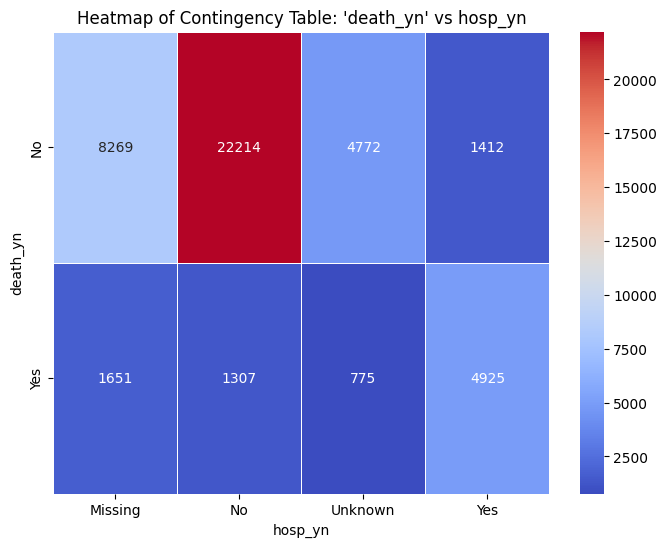

In [14]:
# Visualising the correlation between 'hosp_yn' and 'death_yn'
feature_to_visualize = 'hosp_yn'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

In the chi-square test, a very high correlation between hospitalisation status and death was noted. This is reaffirmed in the heatmap, which highlights that most patients who were not hospitalised did not die from Covid. This is to be expected, as presumably a sicker patient would require hospitalisation. 

While this feature has had data redacted (as denoted by the Missing variable) and it also contains a high count of Unknown values (possibly due to incomplete data on patients, due to inability to contact them), it also illustrates that the hospitalised patients were more likely to die from Covid. This feature may prove useful for further analysis. 

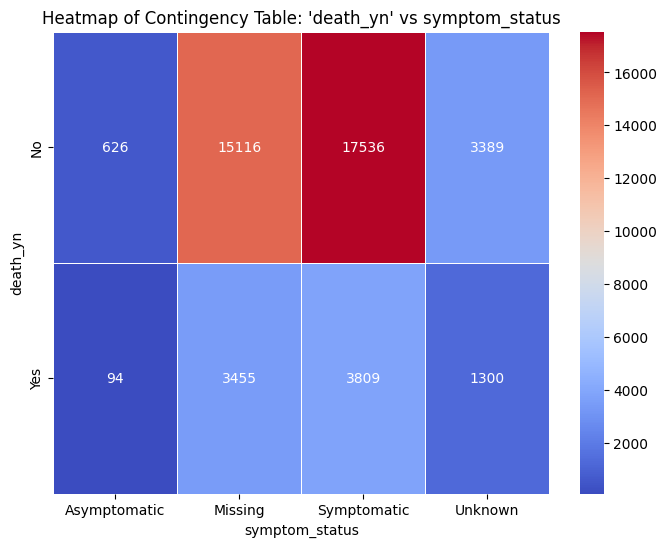

In [13]:
# Visualising the correlation between 'symptom_status' and 'death_yn'
feature_to_visualize = 'symptom_status'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

As with other heatmaps, this chart contains evidence of CDC redaction of data. It is also possible that the 'Unknown' values herein relate to unentered data by clinicians, possibly due with an inability to contact patients. 

As with the chi-square test, this heatmap shows significant correlation to 'death_yn'. The majority of patients (who were either symptomatic or data evidence is Missing) did not die from Covid. 

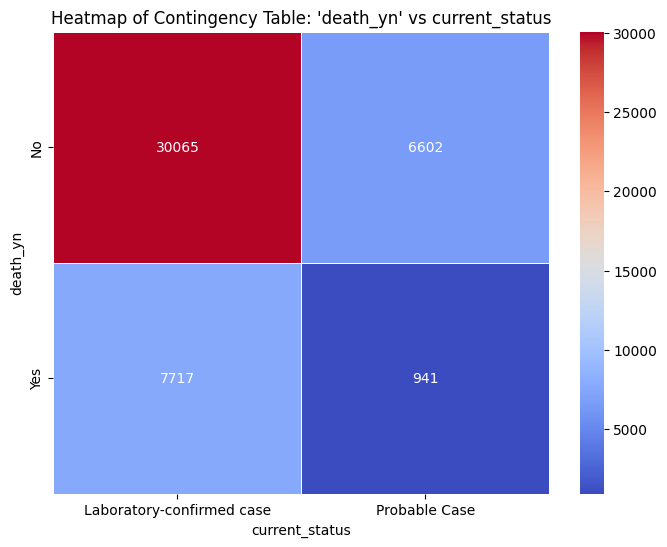

In [12]:
# Visualising the correlation between 'current_status' and 'death_yn'
feature_to_visualize = 'current_status'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

The heat map of this data shows that the majority of patients within 'current_status' were laboratory-confirmed cases. Across both lab-confirmed cases and probable cases, the majority of patients were not dead (from Covid, at any rate) at the time of writing. The correlation between the target feature and current_status is observed in the heatmap. 

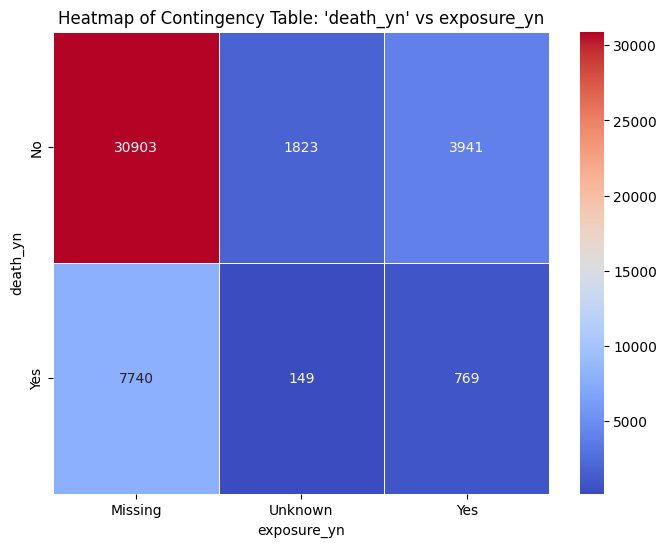

In [11]:
# Visualising the correlation between 'exposure_yn' and 'death_yn'
feature_to_visualize = 'exposure_yn'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

The heatmap between process and the target feature indicates that there is a high occurence of Missing values in the exposure_yn dataset. It is likely that these were redacted to preserve patient anonymity. The heatmap shows that of those patients whose values were redacted, they were less likely to die with Covid 19.

While this is intriguing information, it may not present much benefit in future analysis. 

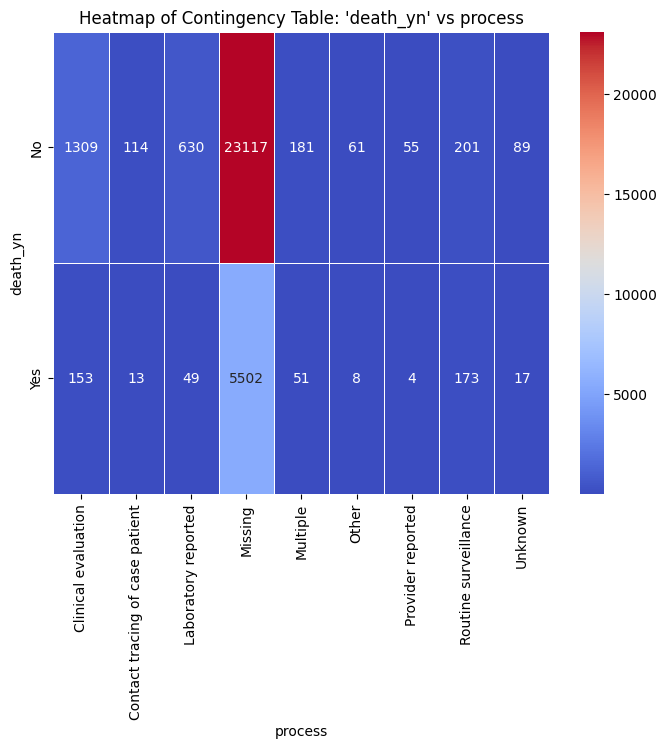

In [18]:
# Visualising the correlation between 'process' and 'death_yn'
feature_to_visualize = 'process'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

This heatmap shows that the feature 'process' contains a high count of Missing values. I believe that this is due to the CDC redacting values to protect patient anonymity, as I have mentioned previously in this report. While the feature does lose some functionality due to the high count of redacted values, it may still be of benefit in further evaluations. For example, we can see that the majority of patients who underwent clinical evaluation did not die. 

From the chi-square value, significant correlation between process and death_yn could be seen. While the heatmap is of merit, it is regrettably limited by the redacted data. 

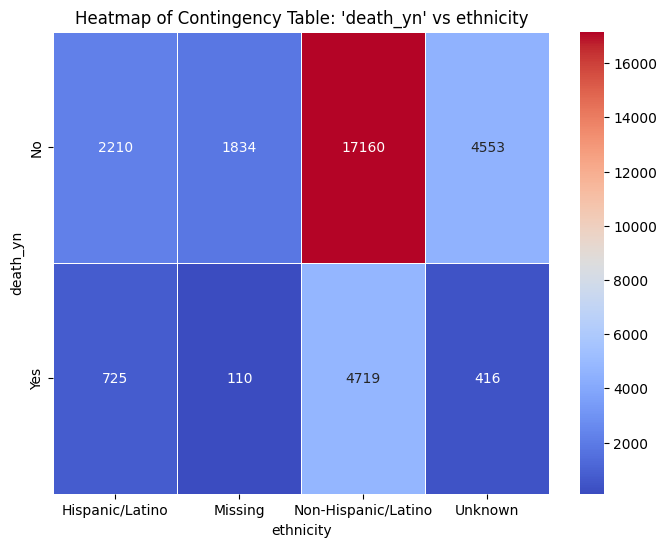

In [16]:
# Visualising the correlation between 'ethnicity' and 'death_yn'
feature_to_visualize = 'ethnicity'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

This heatmap indicates that the overwhelming majority of non-Hispanic/Latino patients did not die from Covid. As the FacetGrid below shows, this dataset is unevenly distributed in terms of ethnicity. Therefore, it is difficult to glean much useful insight into the interplay of ethnicity and death outcomes. While the chi-square value indicated a highly significant correlation between ethnicity and death, due to the skewedness of the dataset, it's limitations must be borne in mind.

/opt/miniconda3/envs/mathsassignment1/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


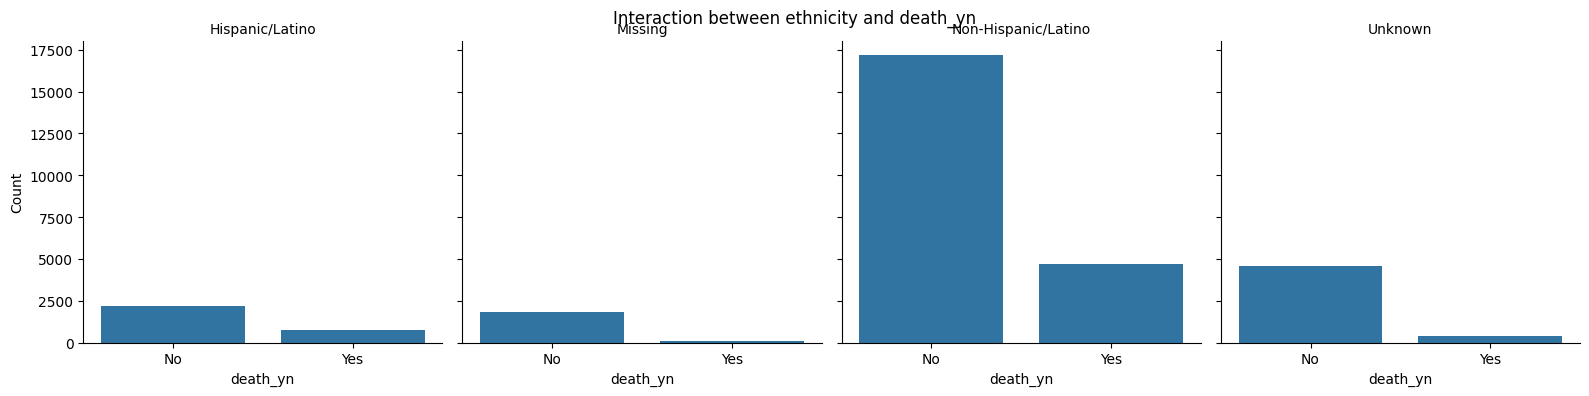

In [17]:
# Generate a FacetGrid of 'ethnicity'
feature = 'ethnicity'

# Create a FacetGrid
g = sns.FacetGrid(df, col=feature, col_wrap=4, height=4)

# Map a plot onto the FacetGrid
g.map(sns.countplot, 'death_yn')

# Set titles for each subplot
g.set_titles('{col_name}')

# Add axis labels and adjust spacing
g.set_axis_labels('death_yn', 'Count')
plt.subplots_adjust(top=0.9)
g.fig.suptitle(f'Interaction between {feature} and death_yn')

# Show the plot
plt.show()

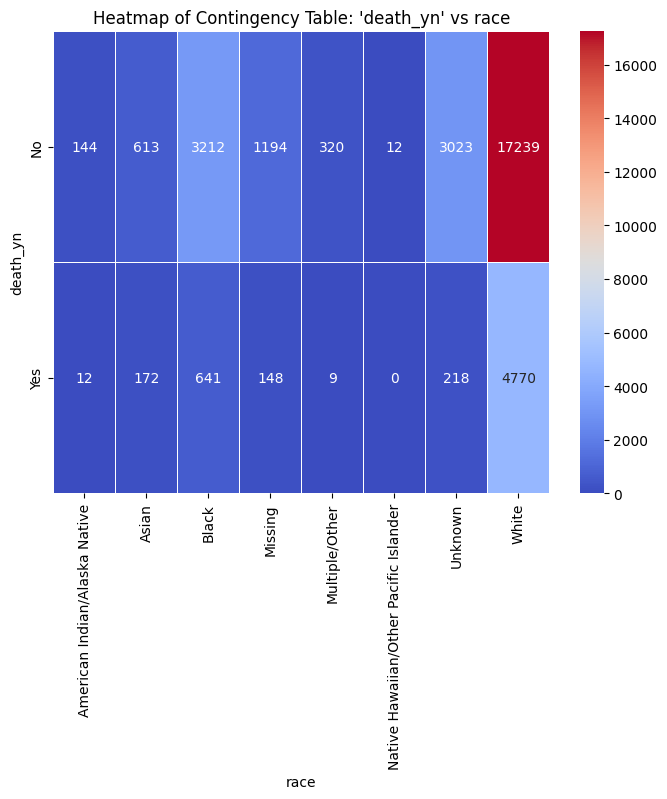

In [14]:
# Visualising the correlation between 'race' and 'death_yn'
feature_to_visualize = 'race'

# Create contingency table for chi-square test
contingency_table = pd.crosstab(df['death_yn'], df[feature_to_visualize])

# Create heatmap of the contingency table
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', fmt='d', linewidths=.5)
plt.title(f"Heatmap of Contingency Table: 'death_yn' vs {feature_to_visualize}")
plt.xlabel(feature_to_visualize)
plt.ylabel('death_yn')
plt.show()

The 'race' heatmap displays does not display much useful information in terms of correlation between death and race. It does indicate that the overwhelming majority of White patients did not die from Covid-19. However, the FacetGrid below shows that this dataset is heavily skewed towards White patients. As it lacks a fair distribution of races, it may be unable to fairly assess the correlation of race and death outcomes across all patients, unless the model significantly focuses on or acknowledges the preponderance of White patients in the training data. 

Therefore, while the earlier chi-square value did indicate some correlation between death and race, due to the dataset lacking a fair distribution of races, this feature may not prove ideal for further analysis and model training. 

/opt/miniconda3/envs/mathsassignment1/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


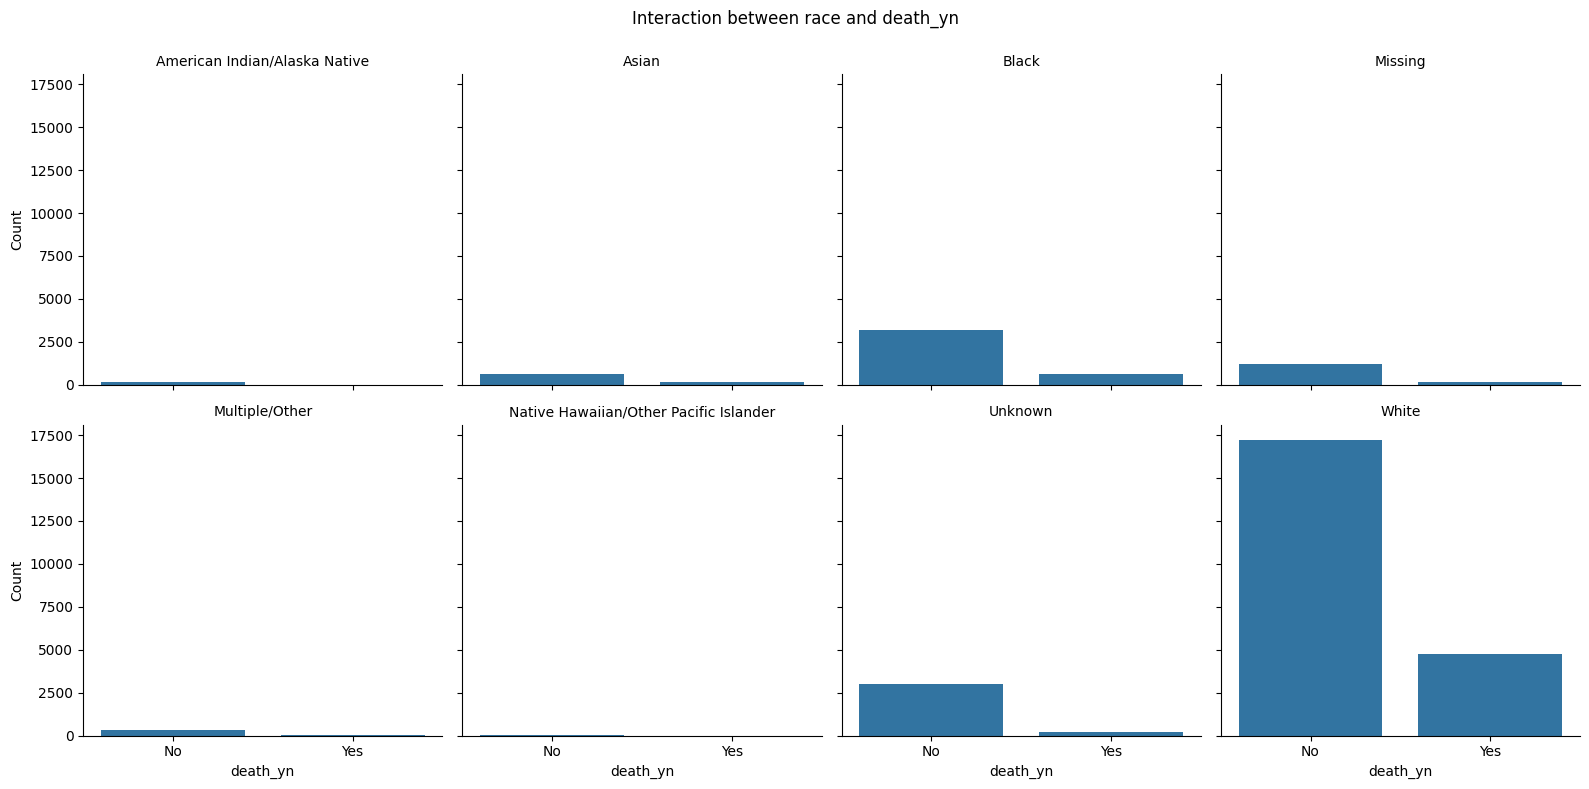

In [15]:
# Generate a FacetGrid of 'race'
feature = 'race'

# Create a FacetGrid
g = sns.FacetGrid(df, col=feature, col_wrap=4, height=4)

# Map a plot onto the FacetGrid
g.map(sns.countplot, 'death_yn')

# Set titles for each subplot
g.set_titles('{col_name}')

# Add axis labels and adjust spacing
g.set_axis_labels('death_yn', 'Count')
plt.subplots_adjust(top=0.9)
g.fig.suptitle(f'Interaction between {feature} and death_yn')

# Show the plot
plt.show()

## Plotting correlations between continuous features and the target feature. ##

In this section of the report, I will plot and discuss the correlations between the continuous features and 'death_yn'. I will use Levene's test to check for homogenity across the categories, as tests such as ANOVA assumes homogenity of variance across the categories. If a feature proves to not have homogenity across the variables, I will use Welch's ANOVA as this does not rely on homogenity of variance. In addition, if ANOVA can not be run, I will utilise an alternative such as Welch's t-test. 

In running Levene's test, I will need to use a temporary copy of the dataframe. This is because I need to convert death_yn to numerical values in order to run the analysis. However, I do not want to convert this for the full dataset, just for this specific test. 

In [12]:
df_temp = df.copy()

# Convert death_yn to numerical in the copy (designating "No" = 0, "Yes" = 1)
df_temp['death_yn'] = df_temp['death_yn'].map({'No': 0, 'Yes': 1})

In [13]:
# List of continuous features
continuous_features = ['state_fips_code', 'county_fips_code', 'case_onset_interval', 'case_positive_specimen_interval']

# List to store test results
levene_results = []

# Loop through each continuous feature and perform Levene's test on each, store results in dictionary
for feature in continuous_features:
  levene_statistic, pval = stats.levene(df_temp['death_yn'], df_temp[feature])
  levene_results.append({
      "feature": feature,
      "levene_statistic": levene_statistic,
      "p-value": pval
  })

# Print results as a table
print("Levene's Test Results:")
print("{:<20} {:>20} {:>20}".format("Feature", "Levene Statistic", "p-value"))
print("-"*70)
for result in levene_results:
  print("{:<20} {:>20.6f} {:>20.6f}".format(result["feature"], result["levene_statistic"], result["p-value"]))

Levene's Test Results:
Feature                  Levene Statistic              p-value
----------------------------------------------------------------------
state_fips_code              46359.770743             0.000000
county_fips_code             40564.364728             0.000000
case_onset_interval            234.145269             0.000000
case_positive_specimen_interval            16.503709             0.000049


Running the Levene's test revealed that: 

- *state_fips_code* and *county_fips_code* : Extremely low p-values suggest strong evidence of unequal variance (possibly due to population density, healthcare access or other factors). 

- *case_onset_interval* and *case_positive_specimen_interval* : These features also have low p-values, but slightly higher than the other two continuous features. There is some evidence of unequal variance but it is less pronounced. 

From the above, I have decided to use Welch's ANOVA for correlation testing in state_fips_code and county_fips_code. It will provide a safer and more reliable results. 

Given that the unequal variances are less severe for case_onset_interval and case_positive_specimen_interval, I will use Welch's t-test for these comparisons.

Initially, I wanted to use ANOVA instead of Welch's t-test. However, the dataset shows unequal group sizes, which caused an inhomogenous shape error when attempting to run ANOVA. Therefore, I have opted to implement an alternative test. 

In [16]:
# Handle missing values (dropping rows)
test_df_clean = test_df.dropna()

print(test_df_clean.groupby('death_yn').size())
#Retaining this code cell as evidence of the unequal group sizes, which rendered ANOVA unusable. 

death_yn
No     10910
Yes     2688
dtype: int64


/var/folders/3t/zmr1xgmj2y52tg8hg56hl6xc0000gn/T/ipykernel_62704/1688824869.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(test_df_clean.groupby('death_yn').size())


In [17]:
# Ensure features are numerical (assuming they are currently strings)
features = ['case_onset_interval', 'case_positive_specimen_interval']
for feature in features:
  test_df_clean[feature] = pd.to_numeric(test_df_clean[feature], errors='coerce')  

# Loop through features and separate data by death_yn
for feature in features:
  death_no = test_df_clean[test_df_clean['death_yn'] == 'No'][feature]
  death_yes = test_df_clean[test_df_clean['death_yn'] == 'Yes'][feature]

  # Perform Welch's t-test
  t_statistic, pval = stats.ttest_ind(death_no, death_yes, equal_var=False)

  # Print results
  print(f"Welch's t-test Results for {feature} (test_df):")
  print(f"t-statistic: {t_statistic}")
  print(f"p-value: {pval}")
  print("-----------------------")

Welch's t-test Results for case_onset_interval (test_df):
t-statistic: -1.4258505240399475
p-value: 0.153967169857739
-----------------------
Welch's t-test Results for case_positive_specimen_interval (test_df):
t-statistic: -1.0922740802278084
p-value: 0.27478194877177775
-----------------------


From running the Welch's t-test, the following can be observed: 

- The t-statistic indicates a trend where the values in "No" might be higher than those in the "Yes" category (which we knew already from the previous code cell). 

- The p-value for case_onset_interval is greater than 0.05. Essentially, there is not enough evidence at the 5% significance level to say that there's a statistically significant difference in distribution in case_onset_interval between the Yes/No death categories. 

- Similarly to the above, the p-value for case_positive_specimen_interval is greater than 0.05. A statistically significant difference between the death categories is not observed. 

Overall, we cannot say that there is a statistically significant correlation between these features and the target feature 'death_yn'. I will now move on to evaluating the correlation between death_yn and the other continuous features (state_fips_code and county_fips_code). While I initially wanted to run Welch's ANOVA with these features, the unequal size in the dataset caused this to be impossible. For this reason, I have resorted to using the chi-square test. 

In [20]:
# Contingency table (assuming death_yn is categorical)
contingency_table = pd.crosstab(test_df_clean['death_yn'], test_df_clean['state_fips_code'])

# Chi-square test
chi2, pval, expected_table, obs_table = stats.chi2_contingency(contingency_table)

# Print results
print(f"Chi-square Test Results for state_fips_code (test_df):")
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {pval}")
print("-----------------------")

Chi-square Test Results for state_fips_code (test_df):
Chi-square statistic: 4232.880961739708
p-value: 0.0
-----------------------


The chi-square result indicates a strong association between the state FIPS code and the death indicator. With a p-value of 0.0, we can reject the null hypothesis. The chi-square statistic indicates the observed distribution, which is high. 

Overall, there is a statistically significant associatoin between the state a person resides in and their death outcome. 

In [21]:
# Contingency table (assuming death_yn is categorical)
contingency_table = pd.crosstab(test_df_clean['death_yn'], test_df_clean['county_fips_code'])

# Chi-square test
chi2, pval, expected_table, obs_table = stats.chi2_contingency(contingency_table)

# Print results
print(f"Chi-square Test Results for county_fips_code (test_df):")
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {pval}")
print("-----------------------")

Chi-square Test Results for county_fips_code (test_df):
Chi-square statistic: 5925.656247100926
p-value: 0.0
-----------------------


The chi-square test results for county_fips_code follow the same interpretation pattern as the results for state_fips_code. Given the strong correlation between the two observed previously in this report, this is no surprise. 

Therefore, this is further confirmation that the location in which people reside is not random with respect to their death outcomes. In fact, the chi-square statistic for the counties is even higher than that for the states, which suggests an even stronger indicator when broken down to county level. 

**Categorical Features that are promising for predicting the target feature**

I have selected the following categorical features for further analysis: 

- hosp_yn: The chi-square test and heatmap jointly confirm a very high correlation between hospitalisation status and death. Therefore, this feature is likely to be critical in future analysis. While it is limited by redacted data, excluding the feature would discard valuable information. 

- sex: Both the heatmap and chi-square test reinforced the notion that sex may be a relevant factor in predicting death risk. 

- age_group: Strong correlation with death_yn (as per p-value). However, due to the dataset being unevenly distributed, analysis with this feature must be carefully conducted. 

- case_month: This is included in order to allow for future evaluation of time trends and their impact on patient mortality. However, I will need to split the column into month and year in order to allow for proper analysis. This will be discussed in the next section. 

- race and ethnicity: I have bracketed these together as the core issues for them revolve around the same point. I believe that these could offer future benefits in analysis. However, the imbalance across races and ethnicities will require proper handling in order to not produce a biased model that performs poorly for people of other races. I will include these features for now but am aware that if the handling techniques perform poorly, these features may need to be dropped.  

Note: ethnicity was later dropped - please read further for the reasoning. 


The following features were excluded:

- res_county: Due to later utilisation of state_fips_codes and county_fips_codes, both of which bear high correlation to the target feature, I considered res_county to be redundant to my analysis. 

- exposure_yn: This feature contains an extremely high count of Missing data, which has been redacted deliberately. Due to this, imputation risks introducing bias, as the data redaction was not at random. Therefore, it is regrettably excluded. 

- icu_yn: While this would have been a useful feature to explore, the analysis above revealed a high incidence of redacted data. As this data was likely specifically redacted to preserve patient anonymity, imputation could have introduced bias. Therefore, I must regrettably exclude it. 

- process: Regrettably contains a high count of Missing data, which has not been redacted at random and therefore would not be ideal for imputation. Regrettably, it must be excluded. 

- current_status: This feature was excluded due to redundancy and the chance of introducing noise from time-dependence into the model. 

- symptom_status: Regrettably excluded due to a high count of Missing data. 

**Continuous Features that are promising for predicting the target feature**

Testing revealed that case_onset_interval and case_positive_specimen_interval did not bear strong correlation to the target feature. For this reason, I will not be investigating them further. It is plausible that in different circumstances and with access to a complete dataset, these features would provide insightful data. 

I have selected the following continuous features for further analysis: 

- state_fips_code 
- county_fips_code 

These features have been selected as they bear strong correlation to one another (as evidenced previously in this dataset). Therefore, they can be used in tandem, as a form of verification method. Additionally (and importantly), both of these features display strong correlation to the target feature 'death_yn'. 

<div style="border: 3px solid black; padding: 10px;">
    <h2 style="color: black;">Section 2: Predictive Modeling - Linear Regression.</h2>
</div>

Before training the models, I need to perform some additional data handling work on the selected features. The issues identified are as follows:

- race and ethnicity: heavily skewed towards one demographic. Need to verify that this is broadly in line with USA norms and if not, handle appropriately. 

- state_fips_code and county_fips_code: Needs to be checked for redacted data, which then requires handling. 

- hosp_yn: Contains much redacted data, which needs to be handled. 

- sex: Needs to be checked for redacted data, which then requires handling. 

- age_group: Heavily skewed towards one age group. 

- case_month: Needs to be converted to datetime data type, then split into two columns, month (categorical) and year (continous) in order to allow the models to work with this data. 

As the linear regression model will require no Missing values, it is imperative that I correct for this before commencing model training. 

**Race and Ethnicity**

Before selecting a strategy for these features, I would firstly like to verify if the count of patients is broadly in line with what should be expected, considering the demographics of the USA. I will print the percentage count of values for each feature, then compare them to official documentation on racial and ethnic demographics of the USA. 

In [22]:
total_entries = len(df)

# Calculate percentages for race
race_percentages = (df['race'].value_counts() / total_entries) * 100

# Print race percentages
print("\nRace Percentages:")
print(race_percentages.round(2))


Race Percentages:
race
White                                     69.62
Unknown                                   14.21
Black                                     12.18
Asian                                      2.50
Multiple/Other                             1.02
American Indian/Alaska Native              0.46
Native Hawaiian/Other Pacific Islander     0.02
Name: count, dtype: float64


In [23]:
# Calculate percentages for ethnicity
ethnicity_percentages = (df['ethnicity'].value_counts() / total_entries) * 100

# Print ethnicity percentages
print("\nEthnicity Percentages:")
print(ethnicity_percentages.round(2))


Ethnicity Percentages:
ethnicity
Non-Hispanic/Latino    69.14
Unknown                21.62
Hispanic/Latino         9.24
Name: count, dtype: float64


I then proceeded to compare these against research based on the 2019 US census, which occurred just before the recording of this data. It informed me that as of 2019, the US population was distributed as follows: 

White: 60.1% (Non-Hispanic)
Hispanic: 18.5%
Black: 12.2%
Asian: 5.6%
Multiple Races: 2.8%
American Indian/Alaska Native: 0.7%
Native Hawaiian/Other Pacific Islander: 0.2%

Resource: https://www.visualcapitalist.com/visualizing-u-s-population-by-race/#:~:text=White%3A%2060.1%25%20(Non%2D,Asian%3A%205.6%25

The above shows that the percentages of my dataset are broadly in line with the demographic spread of the USA. As the categorisation appears to differ slightly, it is impossible to be entirely sure. However, overall it appears to be in line with what is expected. The count of Hispanic/Latino people in my dataset is lower than the official statistics. However, this may be due to the random sample of the dataset, contained within the "Unknown" patients or due to incorrect recording of patient data. 

At this point, I felt that it would not be possible to work with 'ethnicity' due to the lack of clear data within it and that it appeared somewhat unrepresentative of the USA population. For this reason, I have elected to drop it. 

**State FIPS code and County FIPS code**

Before commencing work with this data, I would like to check for any redacted data that needs handling. 

In [24]:
# Check for missing values in the features
state_missing = df['state_fips_code'].isnull().any()
county_missing = df['county_fips_code'].isnull().any()

# Print messages to confirm the above
if state_missing:
  print("There are missing values in the 'state_fips_code' feature.")
else:
  print("There are no missing values in the 'state_fips_code' feature.")

if county_missing:
  print("There are missing values in the 'county_fips_code' feature.")
else:
  print("There are no missing values in the 'county_fips_code' feature.")

There are no missing values in the 'state_fips_code' feature.
There are no missing values in the 'county_fips_code' feature.


Having confirmed the absence of redacted data, I can proceed to the next check. 

**Case Month**

Multiple steps are required in order to make this data suitable for model training. It needs to be converted to datetime data type, then split into two columns, month (categorical) and year (continous) in order to allow the models to work with this data.

In [11]:
# Conversion to datetime data type
df['case_month'] = pd.to_datetime(df['case_month'])

Then, it needs to be split into year and month columns with the correct categorisation. Finally, I will drop the initial case_month value. 

In [12]:
# Extracting 'year' and 'month' from datetime column
df['year'] = df['case_month'].dt.year
df['month'] = df['case_month'].dt.month

# Converting 'month' column to categorical
df['month'] = df['month'].astype(str)  # Convert to string before converting to categorical
df['month'] = pd.Categorical(df['month'])

# Dropping the original 'case_month' column
df.drop(columns=['case_month'], inplace=True)

To confirm that that the above worked as expected, I will print a percentage count of the values in 'year' and 'month' as verification, along with their column types. 

In [13]:
# Print column types for 'year' and 'month' columns
print("Column types for 'year' and 'month' columns:")
print("Year column type:", df['year'].dtype)
print("Month column type:", df['month'].dtype)

Column types for 'year' and 'month' columns:
Year column type: int32
Month column type: category


In [14]:
# Calculate percentage count for 'year'
year_percentage = df['year'].value_counts(normalize=True) * 100

# Calculate percentage count for 'month'
month_percentage = df['month'].value_counts(normalize=True) * 100

print("Percentage count of values in 'year' column:")
print(year_percentage)

print("\nPercentage count of values in 'month' column:")
print(month_percentage)

Percentage count of values in 'year' column:
year
2021    36.792007
2022    30.046963
2020    29.961862
2023     3.199168
Name: proportion, dtype: float64

Percentage count of values in 'month' column:
month
1     19.652031
12    15.668043
11    10.795222
8      8.040470
9      6.845904
10     6.546475
4      6.392032
7      6.354209
5      5.332997
2      5.238440
3      4.942163
6      4.192013
Name: proportion, dtype: float64


**Age Groups**

As mentioned previously, it was observed that age group seemed to skew heavily towards the 18 - 49 year old age bracket. I wish to print this as a percentage and then cross check this against overall USA stats. 

In [27]:
# Calculate percentages for age_group
age_group_percentages = (df['age_group'].value_counts() / total_entries) * 100

# Print age group percentages
print("\nAge Percentages:")
print(age_group_percentages.round(2))


Age Percentages:
age_group
18 to 49 years    39.86
65+ years         28.03
50 to 64 years    17.61
0 - 17 years      14.38
Missing            0.11
Name: count, dtype: float64


I then compared this to the 2021 USA census results. It shows that the dataset is broadly in line with the expected norms for the USA. While the dataset does feature a higher incidence of people in the 18 - 49 age bracket than might be expected, this could be explained by the fact that typically, children did not become as ill with Covid-19 than older patients. Therefore, the lower incidence of people in the 0-17 age bracket makes sense. 

Under 18 years	22.2% 
18–44 years	35.9% 
45–64 years	25.2% 
65 and over	16.8% 

Resource: https://en.wikipedia.org/wiki/Demographics_of_the_United_States

Given that the Missing values are negligible, I can leave these in place for now. 

**Sex**

Before proceeding with the work, I would like to check the sex feature for completeness and any missing values. 

In [30]:
# Calculate percentages for sex
sex_percentages = (df['sex'].value_counts() / total_entries) * 100

# Print sex percentages
print("\nSex Percentages:")
print(sex_percentages.round(2))


Sex Percentages:
sex
Female     52.16
Male       47.35
Unknown     0.42
Missing     0.07
Name: count, dtype: float64


The above confirms a broadly even split of data and neglible counts of Missing/Unknown data, which means I can proceed with the analysis. 

**Hospitalisation Status**

Finally, I would like to check the count of redacted data in hosp_yn. 

- hosp_yn: Contains much redacted data, which needs to be handled. 

In [31]:
# Calculate percentages for hosp_yn
hosp_percentages = (df['hosp_yn'].value_counts() / total_entries) * 100

# Print hospitalisation percentages
print("\nHospitalisation Percentages:")
print(hosp_percentages.round(2))


Hospitalisation Percentages:
hosp_yn
No         52.18
Missing    21.82
Yes        13.70
Unknown    12.30
Name: count, dtype: float64


The above data displays a significant count of Missing and Unknown data, which may cause errors. In selecting a method of dealing with this, I considered imputing the missing values with the highest frequency value. However, this would lead to significant bias to No. It must also be considered that these values were not removed at random. They were selected by the CDC for redaction, in order to preserve patient anonymity. Therefore, it could be argued that the incidence of Yes may actually be reasonably high, as it would typically be easier to identify a person who has been hospitalised compared to one who has not. The incidence of hospitalised patients is lower than the percentage count of patients who recovered at home. 

For this reason, it is impossible to fairly impute these values and I must drop them. 

In [ ]:
# Filter out 'Missing' and 'Unknown' values from 'hosp_yn' column
filtered_df = df[(df['hosp_yn'] != 'Missing') & (df['hosp_yn'] != 'Unknown')]

# Recalculate percentages for hospitalization
total_entries_filtered = filtered_df.shape[0]
hosp_percentages_filtered = (filtered_df['hosp_yn'].value_counts() / total_entries_filtered) * 100

# Print filtered hospitalization percentages
print("\nFiltered Hospitalisation Percentages:")
print(hosp_percentages_filtered.round(2))

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">2.1: Linear Regression Model Training.</h2>
</div>

This section of the assignment will train a linear regression model on the training set to predict the target feature, using only the  descriptive features selected above. Firstly, I will one-hot encode the categorical variables. I have chosen this approach as it should work well when dealign with multiple categorical features in linear regression. 

In [30]:
# Specify the columns to one-hot encode
columns_to_encode = ['age_group', 'sex', 'race', 'month', 'year', 'hosp_yn', 'death_yn']

# Perform one-hot encoding
encoded_df = pd.get_dummies(df, columns=columns_to_encode)

# Print column names of the encoded DataFrame
print(encoded_df.columns)

Index(['res_state', 'state_fips_code', 'res_county', 'county_fips_code',
       'ethnicity', 'case_positive_specimen_interval', 'case_onset_interval',
       'process', 'exposure_yn', 'current_status', 'symptom_status', 'icu_yn',
       'age_group_0 - 17 years', 'age_group_18 to 49 years',
       'age_group_50 to 64 years', 'age_group_65+ years', 'age_group_Missing',
       'sex_Female', 'sex_Male', 'sex_Missing', 'sex_Unknown',
       'race_American Indian/Alaska Native', 'race_Asian', 'race_Black',
       'race_Missing', 'race_Multiple/Other',
       'race_Native Hawaiian/Other Pacific Islander', 'race_Unknown',
       'race_White', 'month_1', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'year_2020', 'year_2021', 'year_2022', 'year_2023',
       'hosp_yn_Missing', 'hosp_yn_No', 'hosp_yn_Unknown', 'hosp_yn_Yes',
       'death_yn_No', 'death_yn_Yes'],
      dtype='object')


Following the successful one-hot encoding, I will now train a linear regression model using all the selected features. As a reminder, these are: 
- Continous: state_fips_code, county_fips_code 
- Categorical: hosp_yn, sex, age_group, month, year, race. 

For the target feature, I have selected 'death_yn_Yes' as we are focusing on predicting death of patients and not patient survival. Therefore, I will not be utilising 'death_yn_No'. 

In [65]:
# Define features (X) and target variable (y)
X = encoded_df[['hosp_yn_No', 'hosp_yn_Unknown', 'hosp_yn_Yes', 
                'race_American Indian/Alaska Native', 'race_Asian', 'race_Black', 
                'race_Missing', 'race_Multiple/Other', 'race_Native Hawaiian/Other Pacific Islander', 
                'race_Unknown', 'race_White', 'age_group_0 - 17 years', 'age_group_18 to 49 years', 
                'age_group_50 to 64 years', 'age_group_65+ years', 'age_group_Missing', 
                'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                'sex_Female', 'sex_Male', 'sex_Missing', 'sex_Unknown']]

y = encoded_df['death_yn_Yes']  # As we are focusing on death prediction and not survival prediction 

# Initialize linear regression model
model = LinearRegression()

# Train the model
model.fit(X, y)

# Confirmation message
print("Model training completed successfully!")

Model training completed successfully!


In the training code, I first define the feature matrix (X) and target variable (y) by selecting the relevant columns from the DataFrame. I then initialise a linear regression model using scikit-learn's LinearRegression class. After that, the model is fit to the data using the fit() method, which estimates the coefficients of the linear regression model that best fit the relationship between the features and the target variable (which I will print in the next section).

Once the model training is completed without any errors, a confirmation message is printed to indicate that the model training process has finished successfully. This message serves as a personal checkpoint to ensure that the model has been trained without encountering any issues.

Before continuing with the coefficient analysis, I opted to perform a mean cross-validation. This will indicate the average performance of the model across multiple regression folds. It provides an opportunity for me to check validity and perform corrections before moving on to analysing the coefficients. 

In [33]:
# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Converting scores to positive values and calculate mean
cv_scores = -cv_scores
mean_cv_score = np.mean(cv_scores)

# Print mean cross-validation score
print("Mean Cross-Validation Score:", mean_cv_score)

Mean Cross-Validation Score: 0.06473172305180068


The result above indicates that the model's performance measured by mean squared error is relatively low. This indicates that the model predictions are closer to the actual values and that the model is performing reasonably well in terms of predicting death likelihood. It also indicates that the model is not significantly overfitting the training data and provides a good starting point for future analysis. 

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">2.2: Model Coefficients.</h2>
</div>

When evaluating the coefficient results, I found the initial print outputs to be unwieldy and difficult to interpret. In order to maximise readability, I have opted to 'bunch' the analysis by printing coefficients in groups according to the originating feature. It is my aim to make both analysis and coherence of the discussion more concise and useful by following this method. 

In [29]:
# Filter feature names and coefficients for the 'sex' variable
sex_feature_names = [name for name in feature_names if name.startswith('sex')]
sex_coefficients = [coefficient for name, coefficient in zip(feature_names, model.coef_) if name.startswith('sex')]

# Print the coefficients for the 'sex' variable
print("Coefficients for the 'sex' variable:")
for feature_name, coefficient in zip(sex_feature_names, sex_coefficients):
    print(f"{feature_name}: {coefficient}")

Coefficients for the 'sex' variable:
sex_Female: -90945505481.73172
sex_Male: -90945505481.70103
sex_Missing: -90945505481.66286
sex_Unknown: -90945505481.76212


The coefficients provided by the 'sex' variable are all remarkably large, which is highly unusual and may indicate numerical instability in the model. The values are almost all identical, which is also unusual. It suggests that the model may not effectively differentiate between these sex categories. 

Overall, interpretation of the coefficients is difficult due to the aforementioned factors. The coefficients provide little meaningful information about how each sex category contributes to the prediction. 

In [37]:
# Filter feature names and coefficients for the 'age_group' variable
age_feature_names = [name for name in feature_names if name.startswith('age')]
age_coefficients = [coefficient for name, coefficient in zip(feature_names, model.coef_) if name.startswith('age')]

# Print the coefficients for the 'age_group' variable
print("Coefficients for the 'age_group' variable:")
for feature_name, coefficient in zip(age_feature_names, age_coefficients):
    print(f"{feature_name}: {coefficient}")

Coefficients for the 'age_group' variable:
age_group_0 - 17 years: -10192904127.916922
age_group_18 to 49 years: -10192904127.92437
age_group_50 to 64 years: -10192904127.87023
age_group_65+ years: -10192904127.510218
age_group_Missing: -10192904127.717852


Interpreting the coefficients for the 'age_group' variable reveals similar issues to those observed in the coefficients for 'sex'. The magnitudes for each coefficient are also extremely large, indicating numerical instability in the model as it is improbable that age groups would have such a large impact. 

Due to the large and uniform coefficients, interpreting this data proves challenging. It suggests that the model treats all age groups similarly when predicting the target outcome. 

In [38]:
# Filter feature names and coefficients for the 'race' variable
race_feature_names = [name for name in feature_names if name.startswith('race')]
race_coefficients = [coefficient for name, coefficient in zip(feature_names, model.coef_) if name.startswith('race')]

# Print the coefficients for the 'race' variable
print("Coefficients for the 'race' variable:")
for feature_name, coefficient in zip(race_feature_names, race_coefficients):
    print(f"{feature_name}: {coefficient}")

Coefficients for the 'race' variable:
race_American Indian/Alaska Native: 10994811330.741026
race_Asian: 10994811330.80291
race_Black: 10994811330.760427
race_Missing: 10994811330.744938
race_Multiple/Other: 10994811330.73211
race_Native Hawaiian/Other Pacific Islander: 10994811330.713606
race_Unknown: 10994811330.711687
race_White: 10994811330.770885


The large and uniform coefficients for the 'race' variable indicate similar issues to those mentioned previously. They differ only in the decimal places, with minor variations at that. Therefore, we can assume that the model fails to differentiate between different racial groups effectively. 

In [47]:
# Filter feature names and coefficients for the 'hosp_yn' variable
hosp_feature_names = [name for name in feature_names if name.startswith('hosp')]
hosp_coefficients = [coefficient for name, coefficient in zip(feature_names, model.coef_) if name.startswith('hosp')]

# Print the coefficients for the 'hosp' variable
print("Coefficients for the 'hosp' variable:")
for feature_name, coefficient in zip(hosp_feature_names, hosp_coefficients):
    print(f"{feature_name}: {coefficient}")

Coefficients for the 'hosp' variable:
hosp_yn_No: -0.0866016595933997
hosp_yn_Unknown: -0.009461528904153471
hosp_yn_Yes: 0.35136363680513893


The coefficients for the 'hosp_yn' variable present a stark contrast to those previously observed and discussed. Unlike the coefficients of 'sex', 'age_group' and 'race', these coefficients are small and fall within a reasonable range. The coefficients for different hospitalisation status also exhibit meaningful differentiation. Specifically, the coefficient for 'hosp_yn_Yes' is notably higher than those for 'hosp_yn_No' and 'hosp_yn_Unknown'. This differentiation suggests that the model distinguishes between these categories when predicting the target death_yn variable.

A positive coefficient for 'hosp_yn_Yes' implies that individuals with a history of hospitalisation are associated with a higher likelihood of death. Conversely, negative coefficients for 'hosp_yn_No' and 'hosp_yn_Unknown' suggest that these categories are associated with a lower likelihood of death.

In [49]:
# Filter feature names and coefficients for the 'month' variable
month_feature_names = [name for name in feature_names if name.startswith('month')]
month_coefficients = [coefficient for name, coefficient in zip(feature_names, model.coef_) if name.startswith('month')]

# Print the coefficients for the 'month' variable
print("Coefficients for the 'month' variable:")
for feature_name, coefficient in zip(month_feature_names, month_coefficients):
    print(f"{feature_name}: {coefficient}")

Coefficients for the 'month' variable:
month_1: 11092484381.508863
month_2: 11092484381.452997
month_3: 11092484381.451563
month_4: 11092484381.501991
month_5: 11092484381.452372
month_6: 11092484381.417084
month_7: 11092484381.450262
month_8: 11092484381.455294
month_9: 11092484381.429274
month_10: 11092484381.40444
month_11: 11092484381.426378
month_12: 11092484381.439999


The coefficients for the 'month' variable are unusually large and uniform across all months. As with previous analysis, it indicates numerical instability in the model. Such large coefficients are not interpretable in a meaningful way. 

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">2.3: Linear Regression Results.</h2>
</div>

The code snippet below evaluates the performance of the linear regression model. 

Initially, it predicts the target feature values for the first 10 training examples using the predict method of the model. 

Then, it thresholds and console prints the predicted values at 0.5 to obtain the predicted class labels. 

Next, it computes and prints various evaluation metrics, including accuracy, precision, recall, and F1 score, using the predicted class labels obtained from the full training set. This will offer a comprehensive assessment of the model's performance. 

The output of the code will be discussed in the following markdown cell. 

In [67]:
# Predicting target feature values for the first 10 training examples
y_pred_train = model.predict(X_train[:10])

# Thresholding the predicted target feature values at 0.5 as per instructions
y_pred_class_train = (y_pred_train >= 0.5).astype(int)

# Printing the predicted class for the first 10 examples
print("Predicted class for the first 10 examples:")
print(y_pred_class_train)

# Computing evaluation measures on the 70% training set
y_pred_full = model.predict(X_train)
y_pred_class_full = (y_pred_full >= 0.5).astype(int)

accuracy = accuracy_score(y_train, y_pred_class_full)
conf_matrix = confusion_matrix(y_train, y_pred_class_full)
precision = precision_score(y_train, y_pred_class_full)
recall = recall_score(y_train, y_pred_class_full)
f1 = f1_score(y_train, y_pred_class_full)

# Printing the  evaluation measures
print("\nClassification Evaluation Measures:")
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Predicted class for the first 10 examples:
[0 0 0 0 0 1 1 0 0 0]

Classification Evaluation Measures:
Accuracy: 0.8991765493873369
Confusion Matrix:
[[20095   501]
 [ 2058  2727]]
Precision: 0.8447955390334573
Recall: 0.5699059561128527
F1 Score: 0.6806439535754399


In the array for the predicted class for the first 10 examples, 0 represents non-death and 1 represents death. It can be seen from the code above that overall, the model predicts survival for the majority of patients. 

The accuracy is the proportion of correctly predicted instances out of the total number of instances. In this case, I received an accuracy of 0.899. An 89% accuracy can be regarded as relatively high accuracy in the model. 

The confusion matrix is the count of true positive, true negative, false positive and false negative predictions in the model. In this instance, the top-left cell (20095) represents the number of true negatives (non-death instances correctly classified as non-death). The top-right cell (501) represents the number of false positives (non-death instances incorrectly classified as death). The bottom-left cell (2058) represents the number of false negatives (death instances incorrectly classified as non-death). The bottom-right cell (2727) represents the number of true positives (death instances correctly classified as death).

The confusion matrix indicates that overall, the model performs well in correctly classifying non-death instances. There is room for improvement in correctly identifying death instances, as shown by the relatively high count of false negatives. Lowering this count is crucial for improving the model sensitivity. 

The precision of the model is 84.5%, which is a relatively good ability of the model to avoid falsely labelling non-deaths as deaths. 

The recall of the model was approximately 57%. It shows that while the model has some ability to detect deaths, there is also room for improvement considering that it missed approximately 43% of the deaths. 

The F1 score is the mean of precision and recall. In this case, the F1 score suggests a moderate balance of precision and recall. The model achieves a reasonable trade-off between correctly identifying deaths and minimising false positives. 

Overall, the model exhibits strong accuracy, which I believe is due to the strong performance of the 'hosp_yn' coefficients. However, the confusion matrix indicates that the model could be enhanced to correctly capture death instances. 

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">2.4: Generalisability Evaluation.</h2>
</div>

**Test dataset evaluation**

Initially, I will need to read in the test_data file (30% examples, saved previously). I will need to split case_month into month and year values, as I did for the 70% dataset. 

In [70]:
# Loading test_data 
test_data = pd.read_csv("test_data.csv")

# Conversion to datetime data type
test_data['case_month'] = pd.to_datetime(test_data['case_month'])

# Extracting 'year' and 'month' from datetime column
test_data['year'] = test_data['case_month'].dt.year
test_data['month'] = test_data['case_month'].dt.month

# Converting 'month' column to categorical
test_data['month'] = test_data['month'].astype(str)  # Convert to string before converting to categorical
test_data['month'] = pd.Categorical(test_data['month'])

# Dropping the original 'case_month' column
test_data.drop(columns=['case_month'], inplace=True)

# Print column types for 'year' and 'month' columns
print("Column types for 'year' and 'month' columns:")
print("Year column type:", test_data['year'].dtype)
print("Month column type:", test_data['month'].dtype)

Column types for 'year' and 'month' columns:
Year column type: int32
Month column type: category


Next, I will train a linear regression model on this 30% dataset. 

In [72]:
# Specify the columns to one-hot encode
columns_to_encode = ['age_group', 'sex', 'race', 'month', 'year', 'hosp_yn', 'death_yn']

# Perform one-hot encoding
encoded_test_data = pd.get_dummies(test_data, columns=columns_to_encode)

# Define features (X) and target variable (y)
X = encoded_test_data[['hosp_yn_No', 'hosp_yn_Unknown', 'hosp_yn_Yes', 
                'race_American Indian/Alaska Native', 'race_Asian', 'race_Black', 
                'race_Missing', 'race_Multiple/Other', 'race_Native Hawaiian/Other Pacific Islander', 
                'race_Unknown', 'race_White', 'age_group_0 - 17 years', 'age_group_18 to 49 years', 
                'age_group_50 to 64 years', 'age_group_65+ years', 'age_group_Missing', 
                'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                'sex_Female', 'sex_Male', 'sex_Missing', 'sex_Unknown']]

y = encoded_test_data['death_yn_Yes']  # As we are focusing on death prediction and not survival prediction 

# Initialize linear regression model
test_model = LinearRegression()

# Train the model
test_model.fit(X, y)

# Confirmation message
print("Model training completed successfully for the test dataset!")

Model training completed successfully for the test dataset!


I will now evaluate the test model using classification evaluation measures. 

In [73]:
# Predicting target feature values for the test dataset
y_pred_test = test_model.predict(X)

# Threshold the predicted target feature values at 0.5 to get the predicted class
y_pred_class_test = (y_pred_test >= 0.5).astype(int)

# Computing evaluation measures on the full test set
accuracy_test = accuracy_score(y, y_pred_class_test)
conf_matrix_test = confusion_matrix(y, y_pred_class_test)
precision_test = precision_score(y, y_pred_class_test)
recall_test = recall_score(y, y_pred_class_test)
f1_test = f1_score(y, y_pred_class_test)

# Print evaluation metrics on the test dataset 
print("Evaluation Metrics - Test Set:")
print(f"Accuracy: {accuracy_test}")
print(f"Confusion Matrix:\n{conf_matrix_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")

Evaluation Metrics - Test Set:
Accuracy: 0.8999852919546992
Confusion Matrix:
[[10598   312]
 [ 1048  1640]]
Precision: 0.8401639344262295
Recall: 0.6101190476190477
F1 Score: 0.7068965517241379


In analysing these results, I will compare the test result with the original (70% dataset) result. 

- Accuracy: Test set: 0.900 and training set: 0.899. 

- Precision: Test set: 0.840 and training set: 0.845. 

- Recall: Test set: 0.610 and training set: 0.570. 

- F1 Score: Test set: 0.707 and training set: 0.681. 

Overall, the model's performance on the test set is similar to the performance on the training set. However, some slight differences exist (such as a higher recall but lower precision on the test set as compared to the training set). These differences could be due to differing data distribution across the test and training datasets. Additionally, the test set results indicate a slightly better F1 score. This suggests that the test set had a slightly better balance of precision and recall, compared to the training set. 

Regarding the confusion matrix, in both test and training sets the model exhibits a higher number of true negatives compared to false positives. This indicates a good performance on identifying non-death, as noted previously in this report. However, there are notable differences in the count of true positives and false negatives. This suggests the model ability to accurately predict death instances is not consistent.

**Complete dataset evaluation**

This will follow a similar pattern to what is executed above. I will read in the 'cleaned_data' file and convert the case_month feature accordingly. I will also convert all the object features to the category format, as this had been done for test and training data. Finally, I will impute missing values via forward filling (as I did previously) and 

In [93]:
# Loading cleaned_data 
cleaned_data = pd.read_csv("cleaned_data.csv")

# Conversion to datetime data type
cleaned_data['case_month'] = pd.to_datetime(cleaned_data['case_month'])

# Extracting 'year' and 'month' from datetime column
cleaned_data['year'] = cleaned_data['case_month'].dt.year
cleaned_data['month'] = cleaned_data['case_month'].dt.month

# Converting 'month' column to categorical
cleaned_data['month'] = cleaned_data['month'].astype(str)  # Convert to string before converting to categorical
cleaned_data['month'] = pd.Categorical(cleaned_data['month'])

# Dropping the original 'case_month' column
cleaned_data.drop(columns=['case_month'], inplace=True)

# Print column types for 'year' and 'month' columns
print("Column types for 'year' and 'month' columns:")
print("Year column type:", cleaned_data['year'].dtype)
print("Month column type:", cleaned_data['month'].dtype)

Column types for 'year' and 'month' columns:
Year column type: int32
Month column type: category


In [94]:
#Select all columns of type 'object'
object_columns = cleaned_data.select_dtypes(['object']).columns

#Convert object data to type 'category'
for column in object_columns:
    cleaned_data[column] = cleaned_data[column].astype('category')  

cleaned_data.dtypes #reprint all data frame types to evaluate

res_state                          category
state_fips_code                     float64
res_county                         category
county_fips_code                    float64
age_group                          category
sex                                category
race                               category
ethnicity                          category
case_positive_specimen_interval     float64
case_onset_interval                 float64
process                            category
exposure_yn                        category
current_status                     category
symptom_status                     category
hosp_yn                            category
icu_yn                             category
death_yn                           category
underlying_conditions_yn           category
year                                  int32
month                              category
dtype: object

In [95]:
# Identify categorical columns with missing values
categorical_columns_with_missing = cleaned_data.select_dtypes(include=['category']).columns[cleaned_data[cleaned_data.select_dtypes(include=['category']).columns].isnull().any()]

# Impute missing values using forward fill in the categorical columns 
for column in categorical_columns_with_missing:
    cleaned_data[column].fillna(method='ffill', inplace=True)

# Median imputation column selection
columns_to_impute = ['county_fips_code', 'case_positive_specimen_interval', 'case_onset_interval']

for column in columns_to_impute:
    median_value = cleaned_data[column].median()
    cleaned_data[column].fillna(median_value, inplace=True)

# Prove that missing values have been imputed
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
res_state                          0
state_fips_code                    0
res_county                         0
county_fips_code                   0
age_group                          0
sex                                0
race                               0
ethnicity                          0
case_positive_specimen_interval    0
case_onset_interval                0
process                            0
exposure_yn                        0
current_status                     0
symptom_status                     0
hosp_yn                            0
icu_yn                             0
death_yn                           0
year                               0
month                              0
dtype: int64


/var/folders/3t/zmr1xgmj2y52tg8hg56hl6xc0000gn/T/ipykernel_17939/94308287.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_data[column].fillna(method='ffill', inplace=True)
/var/folders/3t/zmr1xgmj2y52tg8hg56hl6xc0000gn/T/ipykernel_17939/94308287.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data[column].fillna(method='ffill', inplace=True)
/var/folders/3t/zmr1xgmj2y52tg8hg56hl6xc0000gn/T/ipykernel_17939/94308287.p

After this initial setup work, I will train a linear regression model on the cleaned dataset. I am using the repeated test/train split approach. 

In [96]:
# Specify the columns to one-hot encode
columns_to_encode = ['age_group', 'sex', 'race', 'month', 'year', 'hosp_yn', 'death_yn']

# Perform one-hot encoding
encoded_cleaned_data = pd.get_dummies(cleaned_data, columns=columns_to_encode)

# Define features (X) and target variable (y)
X = encoded_cleaned_data[['hosp_yn_No', 'hosp_yn_Unknown', 'hosp_yn_Yes', 
                'race_American Indian/Alaska Native', 'race_Asian', 'race_Black', 
                'race_Missing', 'race_Multiple/Other', 'race_Native Hawaiian/Other Pacific Islander', 
                'race_Unknown', 'race_White', 'age_group_0 - 17 years', 'age_group_18 to 49 years', 
                'age_group_50 to 64 years', 'age_group_65+ years', 'age_group_Missing', 
                'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                'sex_Female', 'sex_Male', 'sex_Missing', 'sex_Unknown']]

y = encoded_cleaned_data['death_yn_Yes']  # As we are focusing on death prediction and not survival prediction 

# Convert boolean values to integers in y
y = y.astype(int)

# Perform train/test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize linear regression model
cleaned_model = LinearRegression()

# Train the model
cleaned_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = cleaned_model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Compute evaluation measures on the test set
accuracy = accuracy_score(y_test, y_pred_class)
conf_matrix = confusion_matrix(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

# Print evaluation measures
print("\nEvaluation Metrics - Test Set:")
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Evaluation Metrics - Test Set:
Accuracy: 0.8957199588174731
Confusion Matrix:
[[10655   255]
 [ 1163  1525]]
Precision: 0.8567415730337079
Recall: 0.5673363095238095
F1 Score: 0.6826320501342883


I will first analyse these results by themselves, then compare them to the previously achieved results. 

 - Accuracy: The model achieves an accuracy of approximately 89.57%. This indicates good overall performance. 

- Confusion Matrix: The large number of true negatives (10655) indicates that the model is effective at identifying non-death instances. However, the relatively high number of false positives (255) and false negatives (1163) suggests areas for improvement.

- Precision: Roughly 85.67% of the instances predicted as death by the model were actually deaths. This shows an ability to avoid classifying non-deaths as deaths. 

- Recall: The recall value of approximately 56.73% indicates that about 56.73% of the actual death instances in the dataset were correctly classified as death by the model. This moderate performance indicates that the model may miss some death instances.

 - F1 Score: 68.26% suggests a moderate balance between precision and recall, which is crucial for binary classification tasks. The model performs reasonably well in balancing false positives and false negatives. 

These results indicate that the test/train split model performs reasonably well in identifying death instances, although there is room for improvement, especially in increasing the recall value.

**Overall Results Analysis**

*Accuracy:*
- Training Data: 0.899
- Test Data: 0.900
- Test/Train Split: 0.896

Overall, all three models achieve similar accuracy, with the test data slightly outperforming the others by a small margin.

*Precision:*
- Training Data: 0.845
- Test Data: 0.840
- Test/Train Split: 0.857

The precision metric varies slightly across the models, with the test/train split model exhibiting the highest precision, followed by the training data model.

*Recall:*
- Training Data: 0.570
- Test Data: 0.610
- Test/Train Split: 0.567

The recall metric also shows some variation, with the test data model achieving the highest recall, followed by the training data model.

*F1 Score:*
- Training Data: 0.681
- Test Data: 0.707
- Test/Train Split: 0.683

The F1 score reflects a balance between precision and recall, with the test data model exhibiting the highest F1 score, followed closely by the test/train split model.

*Confusion Matrix:*

All models exhibit a higher number of true negatives compared to false positives, indicating a good performance in identifying non-death instances. However, there are notable differences in the counts of true positives and false negatives among the models, suggesting inconsistencies in the models' ability to accurately predict death instances.

*Overall comparison*

While all three models demonstrate reasonably good performance, there are slight variations in their evaluation metrics. The test data model generally performs slightly better in terms of precision, recall, and F1 score compared to the training data model. The test/train split model also performs comparably, with some metrics slightly higher than the other two models. These differences could be attributed to variations in the data distribution.

<div style="border: 3px solid black; padding: 10px;">
    <h2 style="color: black;">Section 3: Predictive Modeling - Logistic Regression.</h2>
</div>

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">3.1: Training the Logistic Regression Model.</h2>
</div>

This section of the assignment will train a logistic regression model on the training set to predict the target feature. It follows a very similar structure to the layout of the linear regression, in order to aid my own clarity. 

In [174]:
# Specifying the columns to one-hot encode
columns_to_encode = ['age_group', 'sex', 'race', 'month', 'death_yn', 'year', 'hosp_yn']

# Perform one-hot encoding
encoded_df = pd.get_dummies(df, columns=columns_to_encode)

# Define features (X) and target variable (y)
X = encoded_df[['hosp_yn_No', 'hosp_yn_Unknown', 'hosp_yn_Yes', 
                'race_American Indian/Alaska Native', 'race_Asian', 'race_Black', 
                'race_Missing', 'race_Multiple/Other', 'race_Native Hawaiian/Other Pacific Islander', 
                'race_Unknown', 'race_White', 'age_group_0 - 17 years', 'age_group_18 to 49 years', 
                'age_group_50 to 64 years', 'age_group_65+ years', 'age_group_Missing', 
                'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                'sex_Female', 'sex_Male', 'sex_Missing', 'sex_Unknown']]

y = encoded_df['death_yn_Yes']  # As we are focusing on death prediction and not survival prediction 

# Initialising logistic regression model
logistic_model = LogisticRegression()

# Train the model
logistic_model.fit(X, y)

# Confirmation message
print("Logistic regression model training completed successfully!")

Logistic regression model training completed successfully!


In [175]:
X_first_10_train = X[:10]
predicted_classes_first_10_train = logistic_model.predict(X_first_10_train)
print("Predicted class for the first 10 examples:")
print(predicted_classes_first_10_train)

Predicted class for the first 10 examples:
[False False False  True False False False False False False]


<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">3.2: Model Coefficients.</h2>
</div>

In analysing the coefficients, a positive coefficient indicates that an increase in the feature's value is associated with an increase in the log odds of the target variable (the event is more likely). Meanwhile, a negative coefficient indicates that an increase in the value is associated with a decrease in the log odds of the target variable (the event is less likely). The magnitude of the coefficient indicates the strength of the relationship between the feature and target variable. 

Similarly to my experience with the linear regression coefficients, in order to properly analyse the coefficients, I must go through them in groups according to the originating feature. 

In [137]:
# Getting feature names and coefficients
feature_names = X.columns
coefficients = logistic_model.coef_[0]

# Filter feature names and coefficients for features beginning with 'sex'
sex_feature_names = [name for name in feature_names if name.startswith('sex')]
sex_coefficients = [coefficient for name, coefficient in zip(feature_names, coefficients) if name.startswith('sex')]

# Print the coefficients for features beginning with 'sex'
print("Coefficients for features beginning with 'sex':")
for feature_name, coefficient in zip(sex_feature_names, sex_coefficients):
    print(f"{feature_name}: {coefficient}")

Coefficients for features beginning with 'sex':
sex_Female: -0.4082504378594801
sex_Male: 0.025498696186711765
sex_Missing: 0.16866982358610294
sex_Unknown: -1.479711700661676


The coefficients reveal how different gender-related factors influence the likelihood of death. Being female is associated with a lower chance of death compared to males, while having missing gender information suggests a higher likelihood of death. Conversely, individuals with unknown gender have a significantly lower chance of death compared to females. This might indicate underlying demographic or health-related differences between genders that affect mortality rates from Covid. 

In [138]:
# Filter feature names and coefficients for features beginning with 'month'
mont_feature_names = [name for name in feature_names if name.startswith('month')]
month_coefficients = [coefficient for name, coefficient in zip(feature_names, coefficients) if name.startswith('month')]

# Print the coefficients for features beginning with 'month'
print("Coefficients for features beginning with 'month':")
for feature_name, coefficient in zip(month_feature_names, month_coefficients):
    print(f"{feature_name}: {coefficient}")

Coefficients for features beginning with 'month':
month_1: 0.03369008866955954
month_2: -0.9074723770443048
month_3: -0.24436184881140646
month_4: 0.7762852946950787
month_5: -0.25505252667244205
month_6: -0.6304860120570545
month_7: -0.020682543197481303
month_8: 0.0276584160169338
month_9: -0.3638981658837854
month_10: -0.43442472650722697
month_11: 0.08361045907979704
month_12: 0.2413403229640504


The coefficients for features beginning with 'month' indicate the impact of different months on the prediction of death outcomes. Some months, such as April and November, have positive coefficients. That suggests a higher likelihood of death occurrences during those months. However months like February, March, June, September, and October have negative coefficients, indicating a lower likelihood of death occurrences. This variation across months reflects the seasonal trends that are commonly known to influence death rates.

In [140]:
# Filter feature names and coefficients for features beginning with 'hosp'
hosp_feature_names = [name for name in feature_names if name.startswith('hosp')]
hosp_coefficients = [coefficient for name, coefficient in zip(feature_names, coefficients) if name.startswith('hosp')]

# Print the coefficients for features beginning with 'hosp'
print("Coefficients for features beginning with 'hosp':")
for feature_name, coefficient in zip(hosp_feature_names, hosp_coefficients):
    print(f"{feature_name}: {coefficient}")

Coefficients for features beginning with 'hosp':
hosp_yn_No: -1.1282572089956158
hosp_yn_Unknown: -0.15617363300940018
hosp_yn_Yes: 2.0734276323683516


The coefficient for 'hosp_yn_Yes' stands out with a value of 2.073. This suggests that being hospitalised significantly increases the likelihood of death. It is also notable that the coefficients for 'hosp_yn_No' and 'hosp_yn_Unknown' are negative, indicating that not being hospitalised or having unknown hospitalisation status reduces the likelihood of death. 

This contrast highlights the importance of hospitalisation status as a predictive feature for death outcomes in the model.

In [141]:
# Filter feature names and coefficients for features beginning with 'age'
age_feature_names = [name for name in feature_names if name.startswith('age')]
age_coefficients = [coefficient for name, coefficient in zip(feature_names, coefficients) if name.startswith('age')]

# Print the coefficients for features beginning with 'age'
print("Coefficients for features beginning with 'age':")
for feature_name, coefficient in zip(age_feature_names, age_coefficients):
    print(f"{feature_name}: {coefficient}")

Coefficients for features beginning with 'age':
age_group_0 - 17 years: -4.093229791866184
age_group_18 to 49 years: -1.7687604425839116
age_group_50 to 64 years: 0.1326146793417997
age_group_65+ years: 2.5983519561142234
age_group_Missing: 1.4372299802454995


There is a clear trend in the coefficients, where the likelihood of death generally increases with age. 

The most substantial impact is observed in the age groups '65+ years' and '0 - 17 years', with respective coefficients of 2.598 and -4.093. This indicates a significant association between older age and higher mortality rates, as well as a notably lower risk of death for children and adolescents. 

The presence of missing age data ('age_group_Missing') also shows a positive coefficient, suggesting that instances with missing age information may have a higher likelihood of death. It lends further credence to earlier suspicions that such data may have been redacted in order to protect severely ill patients who may have been more identifiable. 

Overall, these coefficients underscore the importance of age as a critical predictor for death outcomes in the model.

In [142]:
# Filter feature names and coefficients for features beginning with 'race'
race_feature_names = [name for name in feature_names if name.startswith('race')]
race_coefficients = [coefficient for name, coefficient in zip(feature_names, coefficients) if name.startswith('race')]

# Print the coefficients for features beginning with 'race'
print("Coefficients for features beginning with 'race':")
for feature_name, coefficient in zip(race_feature_names, race_coefficients):
    print(f"{feature_name}: {coefficient}")

Coefficients for features beginning with 'race':
race_American Indian/Alaska Native: 0.10743346214121009
race_Asian: 0.7788983155031487
race_Black: 0.11735262990986803
race_Missing: -0.44657182048960953
race_Multiple/Other: -1.6243389701499529
race_Native Hawaiian/Other Pacific Islander: -0.06274007605972406
race_Unknown: -0.8066264704581285
race_White: 0.2427993108549069


In this set of results, several racial categories exhibit positive coefficients. This indicates an increased likelihood of death compared to the target feature 'death_yn_Yes'. For instance, the coefficients for 'race_Asian' and 'race_Black' are notably positive, suggesting a higher risk of death among people of these racial groups. Negative coefficients, such as those for 'race_Missing' and 'race_Unknown', suggest a reduced likelihood of death compared to the reference category. This may be due to underrepresentation.

These coefficients highlight the complex interplay between race and mortality outcomes. In analysing these, access to contextual factors such as socioeconomic status, access to healthcare, and other factors could prove illuminating. Sadly, these are not accessible in my dataset. 

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">3.3: Predicted Target & Evaluation Summary.</h2>
</div>

In [155]:
# Predicting target variable for the entire training set and computing scores
y_pred_train = logistic_model.predict(X)
accuracy = accuracy_score(y, y_pred_train)
conf_matrix = confusion_matrix(y, y_pred_train)
precision = precision_score(y, y_pred_train)
recall = recall_score(y, y_pred_train)
f1 = f1_score(y, y_pred_train)

# Printing the set evaluation measures as per task
print("Classification Evaluation Measures on the Full Training Set:")
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Classification Evaluation Measures on the Full Training Set:
Accuracy: 0.9080593815992688
Confusion Matrix:
[[24571  1186]
 [ 1731  4239]]
Precision: 0.7813824884792627
Recall: 0.7100502512562814
F1 Score: 0.7440105309346204


Analysis of the generated results reveals the following: 

- *Accuracy:* The accuracy is approximately 90.81%. This indicates that the model correctly predicts the outcome (whether death occurred or not) for the vast majority of the cases. 

- *Confusion Matrix:* The confusion matrix reveals how well the model performs in classifying instances. In this case, it correctly identifies a substantial number of true positives (4239 - predicted deaths that were deaths) and true non-deaths (24571), but also makes some errors, falsely labeling instances as deaths (1186) or failing to detect actual deaths (1731).

- *Precision:* The precision of the model shows that 78.14% of the predicted deaths are correct.

- *Recall:* The recall values indicates that around 71.01% of the actual deaths are correctly identified by the model.

 - *F1 Score:* This provides a balance between precision and recall. In this case, the F1 score suggests that the model achieves a reasonable balance (74.40%) between correctly identifying deaths and avoiding false positives.

Overall, the logistic regression model performs reasonably well on the training set, with a good balance between accuracy, precision, recall, and F1 score. However, issues are highlighted around false positives/ false negative counts and in the mediocre precision and recall values. While the model exhibits reasonable performance, there are opportunities to refine its predictive capabilities, particularly in improving sensitivity to actual death occurrences.

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">3.4: Model Evaluation & Cross-validation Analysis.</h2>
</div>

**Test dataset evaluation**

In [158]:
# Specifying the columns to one-hot encode
columns_to_encode = ['age_group', 'sex', 'race', 'month', 'death_yn', 'year', 'hosp_yn']

# Perform one-hot encoding on the test dataset
encoded_df = pd.get_dummies(test_data, columns=columns_to_encode)

# Define the features (X) and target variable (y)
X = encoded_df[['hosp_yn_No', 'hosp_yn_Unknown', 'hosp_yn_Yes', 
                'race_American Indian/Alaska Native', 'race_Asian', 'race_Black', 
                'race_Missing', 'race_Multiple/Other', 'race_Native Hawaiian/Other Pacific Islander', 
                'race_Unknown', 'race_White', 'age_group_0 - 17 years', 'age_group_18 to 49 years', 
                'age_group_50 to 64 years', 'age_group_65+ years', 'age_group_Missing', 
                'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                'sex_Female', 'sex_Male', 'sex_Missing', 'sex_Unknown']]

y = encoded_df['death_yn_Yes']  # As we are focusing on death prediction and not survival prediction 

# Initialising logistic regression model
logistic_model = LogisticRegression()

# Train the model
logistic_model.fit(X, y)

# Confirmation message
print("Logistic regression model training completed successfully on the test dataset!")

Logistic regression model training completed successfully on the test dataset!


As a reminder, the test dataset is the 30% dataset set aside at the beginning of this process. I will now proceed to print and analyse the classification evaluation measures on this hold-out set of data, similar to what I did with the 70% dataset analysed previously. 

In [160]:
# Predicting target variable for the 30% testing set and computing scores
y_pred_train = logistic_model.predict(X)
accuracy = accuracy_score(y, y_pred_train)
conf_matrix = confusion_matrix(y, y_pred_train)
precision = precision_score(y, y_pred_train)
recall = recall_score(y, y_pred_train)
f1 = f1_score(y, y_pred_train)

# Printing the set evaluation measures as per assignment task
print("Classification Evaluation Measures on the 30% Testing Set:")
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Classification Evaluation Measures on the 30% Testing Set:
Accuracy: 0.9071186939255773
Confusion Matrix:
[[10381   529]
 [  734  1954]]
Precision: 0.7869512686266613
Recall: 0.7269345238095238
F1 Score: 0.7557532392187197


When compared to the results from the 70% training data, the following can be noted: 

- *Accuracy:* The testing set accuracy (90.71%) is slightly lower than the training set accuracy (90.81%), although this difference is minute. It indicates broadly consistent model performance. 

- *Confusion Matrix:* There are differences in the absolute numbers of false positives and false negatives, although similar counts of true positives and true negatives.

- *Precision:* The precision on the testing set (78.70%) is slightly higher compared to the training set (78.14%), indicating improved accuracy in predicting deaths without falsely classifying non-deaths.

- *Recall:* The recall on the testing set (72.69%) is slightly higher compared to the training set (71.01%). This suggests a better ability to capture actual deaths in the testing data.

- *F1 Score:* The F1 score on the testing set (75.58%) is slightly higher compared to the training set (74.40%). This indicates the model is achieving a better balance when working with the test data. 

The model performs consistently well on both the training and testing sets. There are slight improvements in performance metrics on the testing set, which could indicate effective learning from the training data. These may also be due to data distribution in the testing dataset. 

**Full dataset**

In [164]:
# Specifying the columns to one-hot encode
columns_to_encode = ['age_group', 'sex', 'race', 'month', 'death_yn', 'year', 'hosp_yn']

# Perform one-hot encoding on the complete dataset
encoded_df = pd.get_dummies(cleaned_data, columns=columns_to_encode)

# Define features (X) and target variable (y)
X = encoded_df[['hosp_yn_No', 'hosp_yn_Unknown', 'hosp_yn_Yes', 
                'race_American Indian/Alaska Native', 'race_Asian', 'race_Black', 
                'race_Missing', 'race_Multiple/Other', 'race_Native Hawaiian/Other Pacific Islander', 
                'race_Unknown', 'race_White', 'age_group_0 - 17 years', 'age_group_18 to 49 years', 
                'age_group_50 to 64 years', 'age_group_65+ years', 'age_group_Missing', 
                'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                'sex_Female', 'sex_Male', 'sex_Missing', 'sex_Unknown']]

y = encoded_df['death_yn_Yes']  

# Initialising logistic regression model
logistic_model = LogisticRegression()

# Train the model
logistic_model.fit(X, y)

# Confirmation message
print("Logistic regression model training completed successfully for the full dataset!")

Logistic regression model training completed successfully for the full dataset!


In [168]:
# Perform repeated train/test splits
num_splits = 10  
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = []

for _ in range(num_splits):
    # Separate data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)  

    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_pred = logistic_model.predict(X_test)

    # Calculating evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Append each evaluation metric to respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

# Calculating the mean evaluation metrics over all splits
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_conf_matrix = np.mean(conf_matrices, axis=0)

# Printing the above calculated results 
print("\nMean Evaluation Metrics:")
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1 Score: {mean_f1}")


Mean Evaluation Metrics:
Mean Accuracy: 0.9061920870716282
Mean Precision: 0.7773096699042321
Mean Recall: 0.7105349180390479
Mean F1 Score: 0.74236895059578


As a reminder, the cleaned dataset is the initial dataset I started with at the beginning of this assignment. I will discuss these results in the section below. However, I will briefly discuss the confusion matrix below, before contrasting the confusion matrices in the final section. 

In [169]:
mean_conf_matrix = np.mean(conf_matrices, axis=0)

print("Mean Confusion Matrix:")
print(mean_conf_matrix)

Mean Confusion Matrix:
[[10484.3   526.7]
 [  748.9  1838.1]]


True Negatives (TN): The high average number of true negatives indicates that the model can correctly identify non-death instances and has a good overall prediction ability. 

False Positives (FP): There is a relatively low count of these, indicating that the model does not routinely make errors in predicting non-deaths as deaths. 

False Negatives (FN): The average number of false negatives is relatively higher compared to false positives. We can note that the model misses some instances that are actually deaths, incorrectly predicting them as non-deaths.

True Positives (TP): The average number of true positives is quite high, indicating that the model correctly identifies a considerable number of instances as deaths. However, when this is compared with the count of false negatives, it is clear that improvements could be made. 

Overall, the model can correctly identify non-deaths (high TN) and deaths (high TP), but the false negatives impede its ability to detect all instances of deaths.

**Overall Results Analysis**

*Accuracy:* 
- Training: 90%
- Test: 91%
- Full: 90% (mean score) 

The test dataset showed a slightly higher accuracy in the above results. The general score is very high, suggesting the model's effectiveness in generalising to unseen data.


*Precision:* 
- Training: 78%
- Test: 79%
- Full: 79% (mean score) 

These scores indicate that the model performs relatively well in correctly identifying positive cases, demonstrating a good ability to identify death instances. 


*Recall:* 
- Training: 71%
- Test: 73%
- Full: 71% (mean score) 

We can see from the above that the model misses around 27-29% of actual deaths, which may lead to some missed opportunities for intervention or prediction.


*F1 Score:* 
- Training: 74%
- Test: 76%
- Full: 75% (mean score)

The F1 score suggests a decent balance between precision and recall, indicating that the model achieves reasonable trade-off between correctly identifying deaths and avoiding false positives.


*Confusion Matrix:* 

Across all three datasets, results show that while the model is generally good at classifying instances, it still struggles with misclassifications, especially false negatives. Improving the model's accuracy in classifying instances, particularly those related to deaths, is essential for its reliability.


*Overall Comparison:* 

The logistic regression model demonstrates consistent performance across the datasets, notwithstanding the previously mentioned issue re: false negatives. The performance metrics suggest that the test dataset (30%) exhibits the strongest performance. Overall, it appears that the model generalises well to unseen data. 

<div style="border: 3px solid black; padding: 10px;">
    <h2 style="color: black;">Section 4: Predictive Modeling - Random Forest.</h2>
</div>

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">4.1: Training the Random Forest Model.</h2>
</div>

The code for the random forest model training is below. Initially when training this model, I experimented with not one-hot encoding the categorical variables, as random forest can handle categorical variables directly. However, my model experienced errors when doing so. For this reason, I have opted to one hot encode the variables before training the model. 

In [192]:
# Selecting features and target
features = ['age_group', 'sex', 'race', 'month', 'year', 'hosp_yn']
target = 'death_yn'

# Reminder that 'df' is the 70% dataset set aside at the beginning of this report
X_train = df[features]
y_train = df[target]

# One-hot encoding the columns 
column_transformer = ColumnTransformer(
    [('encoder', OneHotEncoder(), ['age_group', 'sex', 'race', 'month', 'year', 'hosp_yn'])],
    remainder='passthrough')

# Transform features
X_train_encoded = column_transformer.fit_transform(X_train)

# Training and setting up the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)

RandomForestClassifier(random_state=42)

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">4.2: Interpretation of the Model.</h2>
</div>

In order to better understand the random forest model, I would first like to understand which features exert the most influence on the model's prediction. 

In [112]:
# Getting the feature importances and corresponding feature names from the random forest model
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Creating dictionary to map feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

print("Feature Importance Dictionary:")
print(feature_importance_dict)

Feature Importance Dictionary:
{'age_group': 0.029455874275673408, 'sex': 0.08864299637490587, 'race': 0.02392087702790456, 'month': 0.2900916445533041, 'year': 0.0006418203223721844, 'hosp_yn': 0.007048516454606178}


From the above code output, the following observations can be made: 
- 'month' has a relatively high importance score of approximately 0.29, suggesting that it plays a significant role in the model's predictions.
- 'sex' also has a notable importance score of around 0.09, indicating its importance in the decision-making process.
- 'age_group', 'race', 'hosp_yn', and 'year' possess relatively lower importance scores, ranging from approximately 0.03 to 0.00. This implies that these features have less impact on the model's predictions compared to 'month' and 'sex'.

In addition, in order to understand the model, I researched the following areas.

*Decision Trees in Random Forest* 

Decision trees are machine learning algorithms that build a model in a flowchart type structure, following 'if-then-else' logic. They allow continous data splitting until a final decision is reached. Starting at a single node (root node), they then branch into possible outcomes until reaching a terminal node (leaf). The hierarchical structure allows decision trees to capture complex decisions and be inherently interpretable, due to their clear structure. They are an integral part of the random forests model. However, in a deep tree, their influence may diminish. 

*Ensemble Learning* 

Ensemble methods combine several machine learning techniques into one predictive model. In the case of random forests, a collection of decision trees are combined. This provides more reliable and robust predictions as compared to individual models. In random forests, 'bagging' is utilised - a technique which involves training each decision tree subset on a random segment of the data. This reduces variance and overfitting. 

*Aggregation of Predictions* 

Aggregation of predictions is a key step in the process, where predictions from multiple individual decision trees are combined to form the final prediction. The mode  of the predictions across all trees is typically taken as the final prediction, ensuring that the final prediction reflects the consensus of the individual trees. By aggregating predictions in this manner, random forests effectively leverage the diversity of the individual trees, resulting in more robust and accurate predictions compared to any single decision tree.

*Model Complexity* 

This is influenced by various factors, primarily the number of decision trees and the depth of each tree. Each tree of the random forest contributes to the overall complexity of the model. Therefore as the number of trees increases, so does the capacity to capture complex relationships and computational complexity. Deeper trees can capture intricate patterns in the data but may lead to overfitting. Balancing the number of trees and the depth of each tree is essential to strike a balance between model complexity and generalization performance. 

*Interpretability vs Performance* 

While random forests are known for their high predictive accuracy and robustness, their interpretability may be compromised compared to simpler models like individual decision trees. Their ensemble nature leads to a more complex model structure. This can make interpretation challenging, especially as the number of trees/tree depth increases. However, the complexity enables the random forest to capture intricate patterns and demonstrate superior predictive performance.


*Resources used:*
- https://medium.com/geekculture/random-forest-ensemble-method-860aaf4fcd16
- https://www.machinelearningnuggets.com/decision-trees-and-random-forests/
- https://towardsdatascience.com/interpreting-random-forests-638bca8b49ea
- https://stats.stackexchange.com/questions/464949/interpretability-of-random-forest-decisions
- https://graphite-note.com/a-comprehensive-guide-to-random-forest-how-it-works-and-its-applications/

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">4.3: Initial Predictions & Training Evaluation.</h2>
</div>

In [109]:
# Predicted target feature value for the first 10 training examples
predicted_values = rf_model.predict(X_train_encoded[:10])

# Predicted class for the first 10 examples
predicted_classes = ['Yes' if value == 1 else 'No' for value in predicted_values]

# Print the predicted target feature value
print("Predicted Target Feature Value for the First 10 Training Examples:")
print(predicted_values)

# Printing predicted class
print("\nPredicted Class for the First 10 Training Examples:")
print(predicted_classes)

Predicted Target Feature Value for the First 10 Training Examples:
['No' 'No' 'No' 'Yes' 'No' 'No' 'No' 'No' 'No' 'No']

Predicted Class for the First 10 Training Examples:
['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No']


The majority of the predicted target feature values and classes for the first 10 training examples are 'No', indicating that the model mainly predicts the negative class for these instances. The model may be biased towards predicting the majority class or the majority of the instances in the training data could belong to the negative class (in that the patients did not die). At present, this is unclear. 


Further analysis, conducted below, will provide additional insights into the model's behavior and performance.

In [105]:
# Training predictions
y_pred_train = rf_model.predict(X_train_encoded)

# Evaluating the model 
print("Training Set Classification Report:")
print(classification_report(y_train, y_pred_train))

Training Set Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.96      0.96     25757
         Yes       0.83      0.82      0.83      5970

    accuracy                           0.94     31727
   macro avg       0.90      0.89      0.89     31727
weighted avg       0.93      0.94      0.93     31727



From the above, the following observations can be made: 

- The model achieves high precision (96%), recall (96%), and F1-score (96%) for the majority class 'No', indicating its ability to accurately predict instances labeled as 'No'.

- However, the precision, recall, and F1-score for the minority class 'Yes' are lower compared to the majority class. Therefore the model might have difficulty correctly identifying instances labeled as 'Yes'. There could be a potential class imbalance issue in the model.

- The overall accuracy of the model on the training set is 94%.

In [107]:
# Computing confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[24762   995]
 [ 1065  4905]]


The confusion matrix reveals the model correctly predicted 4095 instances of Yes and 24762 instances of No correctly. The model performs well in terms of true positive and true negative predictions, indicating its ability to correctly classify instances as either 'Yes' or 'No'.

However, there is a notable number of false positive and false negative predictions, indicating areas where the model's predictions deviate from the actual labels. There are 995 instances where the model predicted Yes where it should have predicted No and 1065 instances where it predicted No on results that should have been Yes. This is problematic as false positives may lead to unnecessary interventions, while false negatives may result in missed opportunities.

Finally, I have opted to compute the cross-validation score on this random forest model in an effort to get further insight in the performance of this model. 

In [108]:
# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train_encoded, y_train, cv=5)

# Print cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Mean Cross-validation Score:", cv_scores.mean())

Cross-validation Scores: [0.91979199 0.92042231 0.92356186 0.92403467 0.91646966]
Mean Cross-validation Score: 0.9208561004158163


The cross validation scores are rather uniform, indicating a consistent model performance. 
The mean cross-validation score is 0.921. This suggests that the model performs well across different subsets of the training data. 

Overall, the results from the cross-validation indicate that the random forest model's performance is stable and not heavily dependent on the dataset subsection used for training. It suggests that it generalises well to new data and has a high level of predictive accuracy. 

**Overall Review of the Performance**

Taking all of the above into consideration, we can infer the following about the model: 

- *High Accuracy:* With a 94% accuracy rate, the model correctly classifies instances the majority of the time. 

- *Precision and Recall:* Values for both classes ('No' and 'Yes') are relatively high, especially for the majority class 'No'. This suggests that the model is good at correctly identifying instances of both classes, with fewer false positives and false negatives.

- *F1-score:* The harmonic mean of precision and recall is also high for both classes. 

- *Confusion Matrix:* This shows a high number of true positives and true negatives along with relatively low numbers of false positives and false negatives. This suggests that the model effectively discriminates between the two classes.

- *Cross-validation Scores:* The consistent cross-validation scores and the high mean cross-validation score indicate that the model's performance is stable across different subsets of the training data. 

Overall, we can conclude that the random forest model is well-performing and robust, with high accuracy and generalization ability. It effectively discriminates between classes and makes accurate predictions on both training and potentially unseen data.

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">4.4: Random Forest Model Evaluation: Performance on Test and Complete datasets</h2>
</div>

Firstly, I will train a random forest model on the test dataset (30%) before finally conducting random forest training on the full dataset. 

**Test dataset random forest**

In [190]:
# Selecting features and target
features = ['age_group', 'sex', 'race', 'month', 'year', 'hosp_yn']
target = 'death_yn'

# Reminder that 'test_data' is the 30% dataset set aside at the beginning of this report
X_train = test_data[features]
y_train = test_data[target]

# One-hot encoding the columns 
column_transformer = ColumnTransformer(
    [('encoder', OneHotEncoder(), ['age_group', 'sex', 'race', 'month', 'year', 'hosp_yn'])],
    remainder='passthrough')

# Transform features
X_train_encoded = column_transformer.fit_transform(X_train)

# Training and setting up the random forest model for the 30% test data model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)

# Training predictions for the test data
y_pred_train = rf_model.predict(X_train_encoded)

# Evaluating the model 
print("30% Test Data Set Classification Report:")
print(classification_report(y_train, y_pred_train))

30% Test Data Set Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.96      0.96     10910
         Yes       0.85      0.85      0.85      2688

    accuracy                           0.94     13598
   macro avg       0.90      0.90      0.90     13598
weighted avg       0.94      0.94      0.94     13598



When comparing these results to the results obtained from the 70% dataset, the following observations can be made: 

- *Accuracy:* The accuracy of the model remains consistent between the test data set (94%) and the training data set (94%). 

- *Precision and Recall:* For both classes ('Yes' and 'No'), the precision and recall values are slightly higher for the test data set compared to the training data set. 

- *F1-Score:* The F1-score also exhibits similar trends, with slightly higher values for the test data set. This implies that the model achieves a better balance between precision and recall on the test data set compared to the training data set.

- *Support:* The support values differ between the test data set and the training data set due to the different sizes of the data sets. This is to be expected. 

Overall, the random forest model appears to maintain consistent performance across the training and test dataset, with slightly improved performance on the test dataset. This suggests that the model effectively generalises to unseen data. 

In [118]:
# Computing confusion matrix of the test data
conf_matrix = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[10495   415]
 [  410  2278]]


When compared with the training dataset, the following observations can be made on the confusion matrix: 

- In both test and training datasets, the number of true positives and true negatives is higher than false positives and false negatives. This shows that in both test and training datasets, the model correctly predicts the majority of instances. 

- The test dataset confusion matrix shows slightly fewer false positives and false negatives than in the training dataset. Therefore, we can note that the model performs slightly better when analysing the test dataset. 

In [119]:
# Perform cross-validation on the 30% test dataset
cv_scores = cross_val_score(rf_model, X_train_encoded, y_train, cv=5)

# Print cross-validation scores for the test set 
print("Cross-validation Scores:", cv_scores)
print("Mean Cross-validation Score:", cv_scores.mean())

Cross-validation Scores: [0.91360294 0.92389706 0.91580882 0.92460463 0.90695108]
Mean Cross-validation Score: 0.916972908508751


A comparison of the cross-validation score for both the training and test datasets reveals that: 

- The mean cross-validation score for the training dataset (0.9209) is slightly higher than that of the test (0.9170). On average, the model appears to perform marginally better on the training dataset than in the test dataset. 

- The overall trend in the individual cross-validation scores suggests that the model consistently achieves relatively high scores across both test and training datasets. 

**Complete dataset random forest**

This will follow a very similar pattern to that executed above. 

In [126]:
# Selecting features and target
features = ['age_group', 'sex', 'race', 'month', 'year', 'hosp_yn']
target = 'death_yn'

# Reminder that 'cleaned_data' is the entire dataset, as read in previously
X_train = cleaned_data[features]
y_train = cleaned_data[target]

# One-hot encoding the columns 
column_transformer = ColumnTransformer(
    [('encoder', OneHotEncoder(), ['age_group', 'sex', 'race', 'month', 'year', 'hosp_yn'])],
    remainder='passthrough')

# Transform features
X_train_encoded = column_transformer.fit_transform(X_train)

# Training and setting up the random forest model for the full dataset model 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)

# Training predictions for the full data
y_pred_train = rf_model.predict(X_train_encoded)

# Evaluating the model 
print("Full Data Set Classification Report:")
print(classification_report(y_train, y_pred_train))

Full Data Set Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.96      0.96     36667
         Yes       0.82      0.83      0.82      8658

    accuracy                           0.93     45325
   macro avg       0.89      0.89      0.89     45325
weighted avg       0.93      0.93      0.93     45325



From the above results, the following can be noted: 

- The precision for class 'No' is 96%, indicating that the model correctly identifies 96% of the instances labeled as 'No'. For class 'Yes', the precision is 82%, suggesting that the model correctly identifies 82% of the instances labeled as 'Yes'.

- The recall for class 'No' is 96%, indicating that the model captures 96% of all instances labeled as 'No'. For class 'Yes', the recall is 83%, suggesting that the model captures 83% of all instances labeled as 'Yes'.

- The weighted average F1-score for the model is 93%, indicating a good balance between precision and recall across both classes.

- The overall accuracy of the model is 93%, indicating that it correctly classifies 93% of all instances.

Overall, the classification report suggests that the model performs well in distinguishing between the two classes, with high precision, recall, and F1-scores, as well as a high overall accuracy.

In [130]:
# Computing confusion matrix of the full data
conf_matrix = confusion_matrix(y_train, y_pred_train)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[24762   995]
 [ 1065  4905]]


From the confusion matrix, the following can be observed. 

- A higher number of true positives and true negatives as compared to false negatives and false positives. This indicates it performs reasonably well in distinguishing between the classes. 

- There is still a notable number of false positives and false negatives, suggesting that the model predictive ability is not perfect. 

In [131]:
# Perform cross-validation on the full dataset
cv_scores = cross_val_score(rf_model, X_train_encoded, y_train, cv=5)

# Print cross-validation scores for the full set 
print("Cross-validation Scores:", cv_scores)
print("Mean Cross-validation Score:", cv_scores.mean())

Cross-validation Scores: [0.91979199 0.92042231 0.92356186 0.92403467 0.91646966]
Mean Cross-validation Score: 0.9208561004158163


In the above results, the following can be observed: 

- The individual cross-validation scores range from approximately 0.916 to 0.924, indicating relatively consistent performance. 

- The mean cross-validation score, which is approximately 0.921, suggests that the model performs consistently well across different data partitions, demonstrating its generalisation ability.

Overall, the cross-validation scores indicate that the model's performance is stable and robust and that the model is likely to perform well on unseen data, without overfitting to the training data.

**Overall Results Analysis**

*Accuracy:* 
- Training Data: 94%
- Test Data: 94%
- Full Data: 93% 

The model exhibits robust accuracy across all datasets, which suggests that the model generalizes well to unseen data.


*Precision:* 
- Training Data: No 96%, Yes 82%
- Test Data: No 96%, Yes 85%
- Full Data: No 96%, Yes 82% 

Precision remains high across all datasets. Specifically, for the "No" class, precision remains consistently high at 96% for all datasets, indicating few false positive predictions. Having said that, for the "Yes" class precision is slightly lower.


*Recall:* 
- Training Data: No 96%, Yes 82%
- Test Data: No 96%, Yes 85%
- Full Data: No 96%, Yes 83%

Similar to precision, recall remains consistently high for the "No" class across all datasets, indicating a high ability to correctly identify instances of non-death. However, for the "Yes" class, recall is slightly lower, with the full dataset achieving the highest recall at 83%.


*F1 Score:* 
- Training Data: No 96%, Yes 83%
- Test Data: No 96%, Yes 85%
- Full Data: No 96%, Yes 82%

Similar to precision and recall, the F1 score remains high for the "No" class across all datasets. However, for the "Yes" class, the F1 score is slightly lower, indicating a trade-off between precision and recall.


*Confusion Matrix:* 

The confusion matrices for both the full dataset and the training dataset are identical, indicating consistent performance between the training and evaluation phases. However, the test dataset's confusion matrix shows slightly fewer instances of correct predictions for both classes compared to the other datasets. This suggests a mildly weaker performance and an inconsistency in model performance when applied to unseen data.


*Overall Comparison:* 

Overall, the random forest model demonstrates strong performance across all datasets, with high accuracy, precision, recall, and F1 score. The model shows promise in effectively predicting mortality outcomes.

<div style="border: 3px solid black; padding: 10px;">
    <h2 style="color: black;">Section 5: Improving Predictive Models.</h2>
</div>

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">5.1: Comparison & Assessment of all Models.</h2>
</div>

In selecting the best performing model of the three implemented, I would summarise their performance as follows: 

*Linear Regression:*
- Demonstrates relatively good accuracy, precision, recall, and F1 score. 
- Has some limitations in recall, suggesting it may miss a significant portion of actual deaths. 
- Exhibits consistency in performance across datasets.


*Logistic Regression:* 
- Shows strong accuracy, precision, recall, and F1 score. 
- It struggles with misclassifications, particularly false negatives. 
- Generalises well to unseen data. 
- The model demonstrates consistent performance across datasets.


*Random Forest:* 
- Exhibits robust performance with high accuracy, precision, recall, and F1 score. 
- Shows strong ability in predicting mortality outcomes, with high precision and recall for the "No" class. 
- Overall, indicates few false positives and a high correct count of non-death instances. 
- It shows some inconsistencies in performance when applied to unseen data.


The random forest model appears to have the best performance overall, given its consistently high accuracy, precision, recall, and F1 score. For this reason, I would select it as the best performing model of the set. The random forest model's percentage scores tended to be higher than those of the other two models investigated. 

In order to check this against the baseline value of the dataset, I will print the count of values in 'death_yn' below and compare the previously garnered results to it. 

In [173]:
# Identifying the target variable and determining frequencies 
target_variable = 'death_yn'
class_frequencies = df[target_variable].value_counts()
majority_class = class_frequencies.idxmax()

# Calculating and printing the target variable
class_distribution = class_frequencies / df.shape[0] * 100  
print("Majority Class:", majority_class)
print("Class Distribution:")
print(class_distribution)

Majority Class: No
Class Distribution:
death_yn
No     81.183219
Yes    18.816781
Name: count, dtype: float64


From the above, we can see that 'No' is represented approximately 81% of the time in the dataset. 

As a reminder, the linear regression model achieved the following results for the training examples (where False is 0): 
[0 0 0 0 0 1 1 0 0 0]

And the logistic regression model printed these results: 
[False False False  True False False False False False False]

This was a reason to not select the logistic regression model as the best performing, as its printed results are not in line with the overall percentage values of the dataset. While the linear regression model achieved a result count in line with the actual values of the dataset, the overall classification evaluation measures were weaker than those demonstrated by the random forest model. 

I believe that some of the reasons for random forest demonstrating the best performance may be: 

- Random forest can capture complex non-linear relationships between features and target variables more effectively than linear models like linear regression and logistic regression. Therefore, it can model more intricate patterns in the data.

- Random forest combines multiple decision trees to make predictions. Each tree learns different aspects of the data, and their combined predictions tend to be more accurate as compared to individual trees. Linear regression and logistic regression cannot benefit from such strategies. 

- Random forest automatically selects the most relevant features for prediction. This can help improve model performance by focusing on the most informative variables.

- In general, random forest tends to be more robust to overfitting than the regression models, especially if dealing with high-dimensional datasets or datasets with noisy features.

<div style="border: 2px solid black; padding: 10px;">
    <h2 style="color: black;">5.2: Improvement Strategies for the Random Forest model.</h2>
</div>

While the random forest model already performs well, it could be improved further. 

In order to ensure the fairest test possible, I have decided to take the weakest performing random forest model from the previously generated models and try to improve the performance of it. The weakest of the set (although still performing well) was that computed on the training data. For this reason, I will continue to work with this section of the data. 

I have elected to finetune the random forest hyperparameters, in order to improve the model performance. The code to do so is below. In designing this code, I elected to utilise GridSearch as it would exhaustively evaluate all combinations of hyperparameters. This was quite computationally intensive for my device and while it was able to complete the task, I am not sure if this would have been possible to do efficiently on a more complex dataset. 

In [209]:
# Selecting features and target
features = ['age_group', 'sex', 'race', 'month', 'year', 'hosp_yn']
target = 'death_yn'

# Reminder that 'df' is the 70% dataset set aside at the beginning of this report
X_train = df[features]
y_train = df[target]

# One-hot encoding the columns
column_transformer = ColumnTransformer(
    [('encoder', OneHotEncoder(), ['age_group', 'sex', 'race', 'month', 'year', 'hosp_yn'])],
    remainder='passthrough')

# Transform features
X_train_encoded = column_transformer.fit_transform(X_train)

# Defining the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest classifier, grid search and fit grid to the training data. 
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_encoded, y_train)

# Print best parameters and best score for further discussion
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuracy: 0.9244807187913583


The results above tell me that: 

- max_depth: The best maximum depth for each tree is 20 levels. A higher max depth would allow trees to make more complex splits. However, there is a risk of overfitting if the trees grow too deep. 

- min_samples_leaf: This ensures that each leaf node has enough samples in order to make reliable predictions. The hyperparameters have determined that the leaf nodes in these trees must contain at least 4 samples. 

- min_samples_split: This means that a tree can split a node if it contains at least 2 samples. This helps to prevent overfitting by ensuring each branch must contain a minimum amount of data at the decision points. 

- n_estimators: This delineates the number of decision trees in the model. Generally, increasing the number of trees improves model performance but benefits plateau at a certain point, or additional trees may lead to overfitting. For my random forest model, a collection of 100 trees should be optimal. 

Finally, when measuring how the model performs with unseen data, the cross-validation accuracy with these optimised parameters should be 92%. This is a clear improvement on the results obtained initially with this dataset and a confirmation that this is a valid way to improve the random forest model. 


Finally, I will use the data generated in the hyperparameter tuning to finetune the random forest model. To do this, I will fit the model to the dataset (using the suggetsed hyperparameters) and then assess the overall performance with cross-validation. 

In [211]:
# Create the Random Forest classifier with best hyperparameters (as shown and discussed previously)
best_rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=4, min_samples_split=2, random_state=42)

# Evaluating the best model using cross-validation
cv_scores = cross_val_score(best_rf_model, X_train_encoded, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

Cross-validation scores: [0.92294359 0.92625276 0.92671395 0.92545311 0.92104019]
Mean CV accuracy: 0.9244807187913583


The results above detail the average performance across all folds. 

The cross-validation scores represent the accuracy of the model when evaluated on a particular fold of the training data. Overall, they average to approximately 92% accuracy. Additionally, the mean CV accuracy represents the overall performance of the model on unseen data. This provides a stable estimate of accuracy overall (as compared to the accuracy of individual folds, which may vary). However in this case, it is reflective of the overall trend in the cross-validation scores and indicates steady performance.